 * Improvements:
  - Adding Skip connections

In [ ]:
%%capture
try:
  already_installed
except:  
    !pip install kora
    !pip install dgl
    !pip install dgl-cu101
    !pip install --pre dgl-cu101
    !pip install dgllife
    # !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    # !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    # !pip install -q torch-geometric
    !pip install torch_optimizer
    #!pip install pytorch_lightning
    import sys
    import time
    import dgl
    import dgllife
    import torch 
    import pickle
    from IPython.display import clear_output
    import networkx as nx
    import dgl.function as fn
    import torch.nn.functional as F
    import torch.nn as nn
    sys.path.append('/usr/local/lib/python3.6/dist-packages/') # For using RDKit utilizing KORA
    import kora.install.rdkit
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    from rdkit.Chem.Draw import IPythonConsole
    from rdkit.Chem import ChemicalFeatures
    from rdkit import RDConfig
    from dgllife.utils import featurizers as fs
    from torch.utils.data import DataLoader
    import networkx as nx
    import matplotlib.pyplot as plt
    import torch_optimizer as optim
    # import pytorch_lightning as pl  
    # from pytorch_lightning.metrics.classification import AUROC
    # from pytorch_lightning.metrics.classification import AveragePrecision
    # from pytorch_lightning.metrics.classification import Recall
    # from pytorch_lightning.metrics.classification import Precision
    # from pytorch_lightning.metrics.classification import ConfusionMatrix
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import train_test_split
    import pandas as pd
    import numpy as np
    import itertools
    import os
    %matplotlib inline
    import warnings
    warnings.filterwarnings("ignore")
    # Fix Seeds
    # Set a seed value
    seed_value= 213 
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random 
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `pytorch` pseudo-random generator at a fixed value
    torch.manual_seed(seed_value)
    # 5. Set `dgl` pseudo-random generator at a fixed value
    dgl.seed(seed_value)
    # 6. For layers that introduce randomness like dropout, make sure to set seed values 
    # model.add(Dropout(0.25, seed=seed_value))
    already_installed=True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data Generation 

def bond_is_in_ring_list_one_hot(bond, allowable_set=None, encode_unknown=False):
          list = [3,4,5] # List denotes the size of cycles
          return [bond.IsInRing()]+[bond.IsInRingSize(i) for i in list]

class CanonicalBondFeaturizer(fs.BaseBondFeaturizer):
       def __init__(self, bond_data_field='e', self_loop=False):
        super(CanonicalBondFeaturizer, self).__init__(
            featurizer_funcs={bond_data_field: fs.ConcatFeaturizer(
                [fs.bond_type_one_hot,
                 fs.bond_is_conjugated,
                 fs.bond_is_in_ring,
                 fs.bond_stereo_one_hot,
                 fs.bond_direction_one_hot,
                 bond_is_in_ring_list_one_hot
                 ]
            )}, self_loop=self_loop)
        
CanonicalBondFeaturizer = CanonicalBondFeaturizer()

# Tox21_dataset = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz', compression='gzip').fillna(0)

# Edge_features=[]
# no_edge=[]
# for i in range(Tox21_dataset.smiles.size):
#   try:
#     Edge_features.append(CanonicalBondFeaturizer(Chem.MolFromSmiles(Tox21_dataset.smiles[i]))['e'])
#   except:
#     no_edge.append(i)
#     Edge_features.append('no_edge')

# Tox21_dataset.drop(no_edge, inplace=True)

# for i in range(len(no_edge)):
#   del Edge_features[no_edge[i]-i]

# %cd /content/

# if not os.path.exists("/content/tox21-global-cdf-rdkit.csv"):
#   !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/tox21-global-cdf-rdkit.zip'
#   !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/Node_features_AF_NOH.zip'

# global_fetures = torch.Tensor(pd.read_csv('tox21-global-cdf-rdkit.csv').iloc[:,1:].values)
# with open('Node_features_AF_NOH.pickle', 'rb') as handle:
#     Node_features = pickle.load(handle)
1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.# for i in range(len(no_edge)):
#   del Node_features[no_edge[i]-i]

# for i in range(len(no_edge)):
#   global_fetures = global_fetures [torch.arange(global_fetures.size (0))!= no_edge[i] - i]

class DGLDatasetTox(torch.utils.data.Dataset):

    def __init__(self):

        Tox21_dataset = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz', compression='gzip').fillna(0)
        
        Edge_features=[]
        no_edge=[]
        for i in range(Tox21_dataset.smiles.size):
          try:
            Edge_features.append(CanonicalBondFeaturizer(Chem.MolFromSmiles(Tox21_dataset.smiles[i]))['e'])
          except:
            no_edge.append(i)
            Edge_features.append('no_edge')

        Tox21_dataset.drop(no_edge, inplace=True)

        for i in range(len(no_edge)):
          del Edge_features[no_edge[i]-i]

        %cd /content/

        if not os.path.exists("/content/tox21-global-cdf-rdkit.csv"):
          !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/TOX21_Node_features_5AF_OH_Yb-solved.zip'
          !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/tox21-global-cdf-rdkit.zip'
          #!unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/Node_Features_AF3_NOH.zip'

        #global_fetures = torch.Tensor(pd.read_csv('tox21-global-cdf-rdkit.csv').fillna(0).iloc[:,1:].values) # 101 NaN: should be addrressed correctly
        gf_df = pd.read_csv('tox21-global-cdf-rdkit.csv')
        global_fetures = torch.Tensor(gf_df.fillna(gf_df.mean()).iloc[:,1:].values) # 101 NaN; fill mean

        #with open('Node_Features_AF3_NOH.pickle', 'rb') as handle:
        with open('TOX21_Node_features_5AF_OH_Yb-solved.pickle', 'rb') as handle:
            Node_features = pickle.load(handle)
        #Node_features[1910][1][-3] = 1.1 # problem with the atom # # with three additional features
        if torch.isnan(Node_features[1910][1][-5]) == True: # # with five additional features
          Node_features[1910][1][-5] = 1.1

        for i in range(len(no_edge)):
          del Node_features[no_edge[i]-i]

        for i in range(len(no_edge)):
          global_fetures = global_fetures [torch.arange(global_fetures.size (0))!= no_edge[i] - i]

        self.dgl_graphs = []
        for i in range(len(Node_features)):
          mol = Chem.MolFromSmiles(Tox21_dataset.iloc[i,-1])
          self.dgl_graphs.append(dgllife.utils.mol_to_bigraph(mol, canonical_atom_order=False))
          self.dgl_graphs[i].ndata['h_0'] = Node_features[i]
          self.dgl_graphs[i].edata['e_0'] = Edge_features[i]

        self.smiles = []
        for o in range(len(self.dgl_graphs)):
          self.smiles.append(Tox21_dataset.iloc[o,13])
          
        self.global_fetures = global_fetures
        self.labels = Tox21_dataset.iloc[:,:12].values
        self.masks = Tox21_dataset.replace({0: 1}).iloc[:,:12].values        
        
        # # Unzip the dataset and read its csv file, and fill in NaN values with 0
        # self.csv = pd.read_csv(csv_url, compression='gzip').fillna(0) 

        # # Make masks for labels (0 as NaN value, and 1 as other values)
        # self.masks_csv = pd.read_csv(csv_url, compression='gzip').replace({0: 1}).fillna(0)

        # # Split smiles, labels, and masks columns as lists
        # self.smiles = self.csv.iloc[:,13]
        # self.labels = self.csv.iloc[:,:12].values
        # self.masks = self.masks_csv.iloc[:,:12].values 

    def __len__(self):
        return len(self.dgl_graphs)

    def __getitem__(self, idx):
        return  self.smiles[idx], self.dgl_graphs[idx], self.global_fetures[idx], torch.Tensor(self.labels[idx]), torch.Tensor(self.masks[idx])
        
dataset = DGLDatasetTox()

# Train, validation, and test set split
#train_set, val_set, test_set = dgllife.utils.ScaffoldSplitter.train_val_test_split(dataset, frac_val=0.1, frac_test=0.1, scaffold_func="smiles")
train_set, val_set, test_set = dgllife.utils.RandomSplitter.train_val_test_split(dataset, frac_val=0.1, frac_test=0.1)

def collate(batch):
    # batch is a list of triples (graphs, labels, masks)
    # Concatenate a sequence of graphs
    
    smiles = [e[0] for e in batch]
    
    graphs = [e[1] for e in batch]
    g = dgl.batch(graphs)

    gf = [e[2] for e in batch]
    gf = torch.stack(gf, 0)

    # Concatenate a sequence of tensors (labels) along a new dimension
    labels = [e[3] for e in batch]
    labels = torch.stack(labels, 0)

    # Concatenate a sequence of tensors (masks) along a new dimension
    masks = [e[4] for e in batch]
    masks = torch.stack(masks, 0)

    return smiles, g, gf, labels, masks

def loader(batch_size=64):

    train_dataloader = DataLoader(train_set,
                              batch_size=batch_size,
                              collate_fn=collate,
                              drop_last=False,
                              shuffle=True)

    val_dataloader =  DataLoader(val_set,
                             batch_size=batch_size,
                             collate_fn=collate,
                             drop_last=False,
                             shuffle=False)

    test_dataloader = DataLoader(test_set,
                             batch_size=batch_size,
                             collate_fn=collate,
                             drop_last=False,
                             shuffle=False)
    
    return train_dataloader, val_dataloader, test_dataloader

# borrowed form: https://stackoverflow.com/a/62508086
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
#count_parameters(model)

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def my_loss(output, label, mask=None):
    criterion = nn.BCELoss(reduction='none')
    if mask == None:
        loss = torch.sum(torch.mean(criterion(output,label), axis=1))
    else: 
        loss = torch.sum(torch.mean(mask*criterion(output,label), axis=1))
    return loss 

def train_model(model, batch_size, optimizer, patience=10, n_epochs=1):
    #metric=AUROC()
    metric = roc_auc_score
    train_dataloader, val_dataloader, test_dataloader  = loader(batch_size)
    train_losses = []
    val_losses = []
    test_aucs = []
    early_stopping = EarlyStopping(patience=patience, verbose=True) # initialize the early_stopping object
    start_time = time.time()
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(1, n_epochs+1):
        epoch_train_loss = 0
        epoch_val_loss = 0
        
        model.train() #Prepare model for training
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(train_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            loss_train = my_loss(prediction, labels, masks)
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            epoch_train_loss += loss_train.detach().item()
        epoch_train_loss /= (len(train_set))
        train_losses.append(epoch_train_loss)

        model.eval() #Prepare model for evaluation
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(val_dataloader):
              mol_dgl_graph=mol_dgl_graph.to(device)
              labels=labels.to(device)
              masks=masks.to(device)
              fg=fg.to(device)
              prediction = model(mol_dgl_graph, fg)
              loss_val = my_loss(prediction, labels, masks)
              epoch_val_loss += loss_val.detach().item()
        epoch_val_loss /= (len(val_set))
        
        with torch.no_grad():
          iter = 0
          prediction_all= torch.empty(0, device=device)
          labels_all= torch.empty(0, device=device)
          masks_all= torch.empty(0, device=device)
          for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
              mol_dgl_graph=mol_dgl_graph.to(device)
              labels=labels.to(device)
              masks=masks.to(device)
              fg=fg.to(device)
              prediction = model(mol_dgl_graph, fg)
              prediction_all = torch.cat((prediction_all, prediction), 0)
              labels_all = torch.cat((labels_all, labels), 0)
              masks_all = torch.cat((masks_all, labels), 0)
          average = torch.tensor([0.], device=device)
          for i in range(12):
            #average += metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) with pytorch-lightening
            average += metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu'))
          test_auc = average.item()/12
               
        epoch_len = len(str(n_epochs))
        clear_output()
        print(f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'Train_Loss: {epoch_train_loss:.5f} ' +
                     f'Valid_Loss: {epoch_val_loss:.5f} ' + 
                     f'Test_AUC: {test_auc:.5f}'          
                     )
        '''
        early_stopping needs the validation loss to check if it has decreased, 
        and if it has, it will make a checkpoint of the current model
        '''
        early_stopping(epoch_val_loss, model)
        val_losses.append(epoch_val_loss)
        test_aucs.append(test_auc)
        if early_stopping.early_stop:
            print("Early Stopping")
            break

    print('\n Training Time was', time.time()-start_time, 'seconds in', device)
    model.load_state_dict(torch.load('checkpoint.pt')) #loading the last checkpoint with the best model

    print('\n')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    # Draw lines
    axes[0].plot(range(len(train_losses)), train_losses, '--', color="red",  label="Train loss")
    axes[0].plot(range(len(val_losses)), val_losses, color="green", label="Validation loss")
    # Create plot
    axes[0].set_title("Learning Curve")
    axes[0].set_xlabel("Epoch"), axes[0].set_ylabel("Cross entropy loss"), axes[0].legend(loc="best")
    # Draw lines
    axes[1].plot(range(len(test_aucs)), test_aucs, color="green", label="TEST AUC")
    # Create plot
    axes[1].set_title("TEST AUC During Training")
    axes[1].set_xlabel("Epoch"), axes[1].set_ylabel("TEST AUC"), axes[1].legend(loc="best")
    plt.show()
 
    with torch.no_grad():
        iter = 0
        prediction_all= torch.empty(0, device=device)
        labels_all= torch.empty(0, device=device)
        masks_all= torch.empty(0, device=device)
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            prediction_all = torch.cat((prediction_all, prediction), 0)
            labels_all = torch.cat((labels_all, labels), 0)
            masks_all = torch.cat((masks_all, labels), 0)
        results = []
        average = torch.tensor([0.], device=device)
        for i in range(12):
          #average += metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) with pytorch-lightening
          results.append(metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu')))
          average += results[i]

    print('\n Test AUC is', average.item()/12)
    print('\n Test AUC in each class is:')
    for i in enumerate(results):
      print(i)

    return  model, train_losses, val_losses, test_aucs

def train_model_scheduler(model, batch_size, optimizer, scheduler, patience=10, n_epochs=1):
    #metric=AUROC()
    metric = roc_auc_score
    train_dataloader, val_dataloader, test_dataloader  = loader(batch_size)
    train_losses = []
    val_losses = []
    test_aucs = []
    
    early_stopping = EarlyStopping(patience=patience, verbose=True) # initialize the early_stopping object
    start_time = time.time()
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_iters = len(train_dataloader)

    for epoch in range(1, n_epochs+1):
        epoch_train_loss = 0
        epoch_val_loss = 0
        
        model.train() #Prepare model for training
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(train_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            loss_train = my_loss(prediction, labels, masks)
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            scheduler.step(epoch + i / train_iters) #scheduler
            epoch_train_loss += loss_train.detach().item()
        epoch_train_loss /= (len(train_set))
        train_losses.append(epoch_train_loss)

        model.eval() #Prepare model for evaluation
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(val_dataloader):
              mol_dgl_graph=mol_dgl_graph.to(device)
              labels=labels.to(device)
              masks=masks.to(device)
              fg=fg.to(device)
              prediction = model(mol_dgl_graph, fg)
              loss_val = my_loss(prediction, labels, masks)
              epoch_val_loss += loss_val.detach().item()
        epoch_val_loss /= (len(val_set))
        
        with torch.no_grad():
          iter = 0
          prediction_all= torch.empty(0, device=device)
          labels_all= torch.empty(0, device=device)
          masks_all= torch.empty(0, device=device)
          for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
              mol_dgl_graph=mol_dgl_graph.to(device)
              labels=labels.to(device)
              masks=masks.to(device)
              fg=fg.to(device)
              prediction = model(mol_dgl_graph, fg)
              prediction_all = torch.cat((prediction_all, prediction), 0)
              labels_all = torch.cat((labels_all, labels), 0)
              masks_all = torch.cat((masks_all, labels), 0)
          average = torch.tensor([0.], device=device)
          for i in range(12):
            #average += metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) with pytorch-lightening
            average += metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu'))
          test_auc = average.item()/12
               
        epoch_len = len(str(n_epochs))
        clear_output()
        print(f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'Train_Loss: {epoch_train_loss:.5f} ' +
                     f'Valid_Loss: {epoch_val_loss:.5f} ' + 
                     f'Test_AUC: {test_auc:.5f}'          
                     )
        '''
        early_stopping needs the validation loss to check if it has decreased, 
        and if it has, it will make a checkpoint of the current model
        '''
        early_stopping(epoch_val_loss, model)
        val_losses.append(epoch_val_loss)
        test_aucs.append(test_auc)
        if early_stopping.early_stop:
            print("Early Stopping")
            break

    print('\n Training Time was', time.time()-start_time, 'seconds in', device)
    model.load_state_dict(torch.load('checkpoint.pt')) #loading the last checkpoint with the best model

    print('\n')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    # Draw lines
    axes[0].plot(range(len(train_losses)), train_losses, '--', color="red",  label="Train loss")
    axes[0].plot(range(len(val_losses)), val_losses, color="green", label="Validation loss")
    # Create plot
    axes[0].set_title("Learning Curve")
    axes[0].set_xlabel("Epoch"), axes[0].set_ylabel("Cross entropy loss"), axes[0].legend(loc="best")
    # Draw lines
    axes[1].plot(range(len(test_aucs)), test_aucs, color="green", label="TEST AUC")
    # Create plot
    axes[1].set_title("TEST AUC During Training")
    axes[1].set_xlabel("Epoch"), axes[1].set_ylabel("TEST AUC"), axes[1].legend(loc="best")
    plt.show()
 
    with torch.no_grad():
        iter = 0
        prediction_all= torch.empty(0, device=device)
        labels_all= torch.empty(0, device=device)
        masks_all= torch.empty(0, device=device)
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            prediction_all = torch.cat((prediction_all, prediction), 0)
            labels_all = torch.cat((labels_all, labels), 0)
            masks_all = torch.cat((masks_all, labels), 0)
        results = []
        average = torch.tensor([0.], device=device)
        for i in range(12):
          #average += metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) with pytorch-lightening
          results.append(metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu')))
          average += results[i]

    print('\n Test AUC is', average.item()/12)
    print('\n Test AUC in each class is:')
    for i in enumerate(results):
      print(i)

    return  model, train_losses, val_losses, test_aucs 

RDKit WARNING: [17:11:23] WARNING: not removing hydrogen atom without neighbors


/content
Archive:  /content/drive/MyDrive/GMLG_Research/Tox_21_Final/TOX21_Node_features_5AF_OH_Yb-solved.zip
  inflating: TOX21_Node_features_5AF_OH_Yb-solved.pickle  
Archive:  /content/drive/MyDrive/GMLG_Research/Tox_21_Final/tox21-global-cdf-rdkit.zip
  inflating: tox21-global-cdf-rdkit.csv  


RDKit WARNING: [17:11:32] WARNING: not removing hydrogen atom without neighbors


In [ ]:
%%capture
if torch.cuda.is_available():  
  device = "cuda:0" 
else:  
  device = "cpu" 

############################################# 
#######################################################################################################################################################
######################################################################################################################################################
class DGM(nn.Module):

    def __init__(self, feat_v_dim, feat_e_dim, feat_g_dim, state_v_dim, state_e_dim, state_g_dim, hidden_e_dim, hidden_m_dim, message_dim, hidden_v_dim, hidden_read_dim, rnn_layers=1, hidden1_alpha_dim=10, hidden2_alpha_dim=10, rnn_initial_state='Default', act1="relu", act2="relu", act3="relu", act4="relu", act5="relu", act6='tanh', act7="relu", num_layers=1):
        super().__init__()
        self.feat_v_dim = feat_v_dim
        self.feat_e_dim = feat_e_dim
        self.feat_g_dim = feat_g_dim
        self.state_v_dim = state_v_dim
        self.state_e_dim = state_e_dim
        self.state_g_dim = state_g_dim
        self.hidden_e_dim = hidden_e_dim
        self.hidden_m_dim = hidden_m_dim
        self.m_dim = message_dim
        self.hidden_v_dim = hidden_v_dim
        self.hidden_read_dim = hidden_read_dim
        #self.rep_dim = rep_dim
        self.rep_dim = self.state_g_dim
        self.hidden1_alpha_dim = hidden1_alpha_dim
        self.hidden2_alpha_dim = hidden2_alpha_dim
        self.num_layers = num_layers
        #self.rnn_layers = rnn_layers 

        self.act1 = eval("torch.nn.functional."+act1)
        self.act2 = eval("torch.nn.functional."+act2)
        self.act3 = eval("torch.nn.functional."+act3)
        self.act4 = eval("torch.nn.functional."+act4)
        self.act5 = eval("torch.nn.functional."+act5)
        self.act6 = act6
        self.act7 = eval("torch.nn.functional."+act7)

        # All linear layers have bias except the message function, for having zero message when input is zero (removed) 
        self.linear_0_v = nn.Linear(self.feat_v_dim, self.state_v_dim)
        self.bn_0_v = nn.BatchNorm1d(self.state_v_dim)
        self.linear_0_e = nn.Linear(self.feat_e_dim, self.state_e_dim)
        self.bn_0_e = nn.BatchNorm1d(self.state_e_dim)
        self.linear_0_g = nn.Linear(self.feat_g_dim, self.state_g_dim)
        self.bn_0_g = nn.BatchNorm1d(self.state_g_dim)
        
        #self.linear_e_0 = nn.Linear(2*self.state_v_dim + 3*self.state_e_dim + self.state_g_dim, self.hidden_e_dim) # without skipconnection
        self.linear_e_0 = nn.Linear(2*self.state_v_dim + 4*self.state_e_dim + self.state_g_dim, self.hidden_e_dim) # with skipconnection
        #self.linear_e_0 = nn.Linear( 3*self.state_e_dim + self.state_g_dim, self.hidden_e_dim)
        self.bn_e_0 = nn.BatchNorm1d(self.hidden_e_dim)
        self.linear_e_1 = nn.Linear(self.hidden_e_dim, self.state_e_dim)
        self.bn_e_1 = nn.BatchNorm1d(self.state_e_dim)

        # Bias = False, for having zero message when input is zero (removed)
        self.linear_m_0 = nn.Linear(self.state_v_dim + self.state_e_dim, self.hidden_m_dim, bias=False)
        self.bn_m_0 = nn.BatchNorm1d(self.hidden_m_dim) 
        self.linear_m_1 = nn.Linear(self.hidden_m_dim, self.m_dim, bias=False)
        self.bn_m_1 = nn.BatchNorm1d(self.m_dim)

        #self.linear_v_0 = nn.Linear(self.state_v_dim + 2*self.m_dim, self.hidden_v_dim) # without skipconnection
        self.linear_v_0 = nn.Linear(2*self.state_v_dim + 2*self.m_dim, self.hidden_v_dim) # with skipconnection
        self.bn_v_0 = nn.BatchNorm1d(self.hidden_v_dim)
        self.linear_v_1 = nn.Linear(self.hidden_v_dim, self.state_v_dim)
        self.bn_v_1 = nn.BatchNorm1d(self.state_v_dim)

        self.linear_r_0 = nn.Linear(self.state_v_dim + 2*state_e_dim, self.hidden_read_dim)
        self.bn_r_0 = nn.BatchNorm1d(self.hidden_read_dim)
        self.linear_r_1 = nn.Linear(self.hidden_read_dim, self.state_g_dim)
        self.bn_r_1 = nn.BatchNorm1d(self.state_g_dim)

        # self.rnn = nn.RNN(self.state_g_dim, self.rep_dim, self.rnn_layers, nonlinearity=self.act6)
        # if rnn_initial_state == 'Default':
        # #   self.rnn_initial_state = torch.Tensor([-3.2917e+01,  3.1963e+02,  6.4549e+02,  1.4563e+04,  2.5602e+02,
        # # -3.2917e+01,  1.9955e+04,  9.4602e+03,  2.2191e+02,  1.5999e+04,
        # #  1.7349e+04,  8.5626e-01,  2.6332e+03,  9.8306e+02,  1.1836e+03,
        # # -2.3718e+01,  6.6943e+03,  1.6386e+04,  4.5242e+02, -3.2917e+01,
        # # -2.6157e+01,  2.9339e+03,  8.3731e+00,  1.2738e+03,  1.2321e+03,
        # # -3.2832e+01,  7.4689e+03,  8.8645e+02, -3.0989e+01,  1.4922e+03]).to(device)
        #   self.rnn_initial_state = torch.randn(self.rnn_layers, self.rep_dim).to(device)
        # else:
        #   self.rnn_initial_state = rnn_initial_state.to(device)

        self.linear_alpha_0 = nn.Linear(2*self.state_v_dim + 3*state_e_dim + self.state_g_dim + self.rep_dim + 1, self.hidden1_alpha_dim)
        self.bn_alpha_0 = nn.BatchNorm1d(self.hidden1_alpha_dim)
        self.linear_alpha_1 = nn.Linear(self.hidden1_alpha_dim, self.hidden2_alpha_dim)
        self.bn_alpha_1 = nn.BatchNorm1d(self.hidden2_alpha_dim)
        self.linear_alpha_2 = nn.Linear(self.hidden2_alpha_dim, 1)
        self.bn_alpha_2 = nn.BatchNorm1d(1, affine=False)

        # self.d1 = torch.nn.Dropout(p=0.2) 
        # self.d2 = torch.nn.Dropout(p=0.2) 
        # self.d3 = torch.nn.Dropout(p=0.2)
        # if bias_v:
        #     self.bias_v = torch.nn.Parameter(torch.FloatTensor(out_feat_1))
        # else:
        #     self.register_parameter('bias_v', None) 

        """Reinitialize learnable parameters."""
        gain1 = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.linear_0_v.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_0_e.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_0_g.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_2.weight, gain=gain1)

    ################################################################
    def alpha_updater(self,input):

      # # It has a depth of 3
      # out = self.act7(self.bn_alpha_0(self.linear_alpha_0(input)))
      # out = self.act7(self.bn_alpha_1(self.linear_alpha_1(out)))
      # out = self.bn_alpha_2(self.linear_alpha_2(out))
      # out = nn.functional.relu(nn.functional.tanh(out))

      #print(input)
      out = self.act7(self.linear_alpha_0(input))
      out = self.act7(self.linear_alpha_1(out))
      out = self.linear_alpha_2(out)
      out = nn.functional.relu(nn.functional.tanh(out))
      #out = nn.functional.relu(out)
      #out = 1/2*(nn.functional.tanh(out)+1)
      #out = nn.functional.sigmoid(out)

      #out = nn.functional.relu(out)
      #out = nn.functional.relu(nn.functional.tanh(self.linear_alpha_2(out)))
      #out = nn.functional.relu(self.linear_alpha_2(out))

      return out

    ################################################################
    def node_reader(self,nodes):

      cat = torch.cat((nodes.data['h'], nodes.data['e_alpha_agg_i'], nodes.data['e_alpha_agg_o']), 1)
      out = self.act5(self.bn_r_0(self.linear_r_0(cat)))
      out = self.act5(self.bn_r_1(self.linear_r_1(out)))

      return {'read' : out}

    ################################################################
    def node_updater(self,nodes):

      cat = torch.cat((nodes.data['h_0'], nodes.data['h'], nodes.data['m_agg_i'], nodes.data['m_agg_o']), 1) # with skipconnection
      #cat = torch.cat((nodes.data['h'], nodes.data['m_agg_i'], nodes.data['m_agg_o']), 1)# without skipconnection
      out=self.act4(self.bn_v_0(self.linear_v_0(cat)))
      out=self.act4(self.bn_v_1(self.linear_v_1(out)))

      return {'h' : out}

    ################################################################
    def edge_message(self,edges):

      cat = torch.cat((edges.src['h'], edges.data['e_alpha']), 1)
      # should not have bias to produce zero output in case of alpha zero 
      out=self.act3(self.bn_m_0(self.linear_m_0(cat)))
      out=self.act3(self.bn_m_1(self.linear_m_1(out)))

      return {'message' : out}


    ################################################################
    def edge_updater(self,input):

      out=self.act2(self.bn_e_0(self.linear_e_0(input)))
      out=self.act2(self.bn_e_1(self.linear_e_1(out)))

      return out

    ################################################################
    def edges_cat_s(self, edges):

      #dose not sees src and dst features
      cat = torch.cat((edges.data['e'], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}
    
    
    ################################################################
    def edges_cat(self, edges):

      #cat = torch.cat((edges.src["h"], edges.dst["h"], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1) # Apparently false
      cat = torch.cat((edges.data['e'], edges.src["h"], edges.src["e_alpha_agg_i"], edges.dst["h"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}

    ################################################################
    ################    Forward      ###################

    def forward(self, mol_dgl_graph, fg):

      # Initialization of the model
      hg=torch.empty(0, device=device)
      hG=torch.empty(0, device=device)
      alpha=torch.empty(0, device=device)
      alpha=torch.cat((alpha, torch.ones(mol_dgl_graph.number_of_edges(), dtype=torch.float, device=device).view(1,-1)), 0)
      mol_dgl_graph_ub = dgl.unbatch(mol_dgl_graph)
      len_batch = len(mol_dgl_graph_ub)
      num_edges_ub = [mol_dgl_graph_ub[i].number_of_edges() for i in range(len_batch)] # dose not take time
      
      # Initial global state
      hg = torch.cat((hg, self.act1(self.bn_0_g(self.linear_0_g(fg))).view(1, len_batch,-1)), 0)
      # hg_0 = self.act1(self.linear_0_g(fg))

      # # RNN in Pytorch
      # # input of shape (seq_len, batch, input_size) 
      # # h_0 of shape (num_layers * num_directions, batch, hidden_size)
      # # output of shape (seq_len, batch, num_directions * hidden_size)
      # # h_n of shape (num_layers * num_directions, batch, hidden_size)
      # h_rnn=[]
      # #h_rnn_0= torch.div(self.rnn_initial_state.repeat(1, len_batch).view(len_batch, -1) + hg[0], 2)
      # h_rnn_0= hg[0]
      # h_rnn.append(h_rnn_0.view(self.rnn_layers, len_batch, -1))
      # #h_rnn.append(self.rnn_initial_state.repeat(1, len_batch).view(self.rnn_layers, len_batch, -1)) # -1 : self.rep_dim

      with mol_dgl_graph.local_scope():

        # Initial edge and node states
        mol_dgl_graph.edata['e_0'] = self.act1(self.bn_0_e(self.linear_0_e(mol_dgl_graph.edata["e_0"])))
        mol_dgl_graph.ndata['h_0'] = self.act1(self.bn_0_v(self.linear_0_v(mol_dgl_graph.ndata["h_0"])))

        #  Initializing edge and node states
        mol_dgl_graph.edata['e'] = mol_dgl_graph.edata['e_0']
        mol_dgl_graph.ndata['h'] = mol_dgl_graph.ndata['h_0']


        # Loop on layers
        for i in range(self.num_layers):
          
          # multiplying edge states by alpha and their aggregation
          mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[0].view(-1,1))
          mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # updating edges
          mol_dgl_graph.apply_edges(self.edges_cat)
          global_states=torch.empty(0, device=device)
          for j in range(len_batch): # dose not take a long time; it's in the order of a few ms (tested!)
            global_states=torch.cat((global_states, hg[i][j].repeat(num_edges_ub[j], 1)), 0)
          #mol_dgl_graph.edata['e_bu'] = torch.cat((mol_dgl_graph.edata['cat'], global_states), 1) # Bu: before updating # without skipconnection
          mol_dgl_graph.edata['e_bu'] = torch.cat((mol_dgl_graph.edata['e_0'], mol_dgl_graph.edata['cat'], global_states), 1) # with skipconnection
          mol_dgl_graph.edata['e'] = self.edge_updater(mol_dgl_graph.edata['e_bu']) # applying the NN function for updating edges

          # multiplying the new edge states by alpha and their aggregation
          mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[0].view(-1,1))
          mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # calculating edge messages
          mol_dgl_graph.apply_edges(self.edge_message)
          
          # aggregating messages
          mol_dgl_graph.update_all(fn.copy_edge('message','m_i'), fn.sum('m_i','m_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('message','m_o'), fn.sum('m_o','m_agg_o_buffer'))
          mol_dgl_graph.ndata['m_agg_o'] = mol_dgl_graph_rev.ndata['m_agg_o_buffer']

          # updating nodes
          mol_dgl_graph.apply_nodes(self.node_updater)

          # reading each node in graph with its incoming and outgoing edges
          mol_dgl_graph.apply_nodes(self.node_reader)

          # representation in this layer: aggregating r from all nodes
          hg = torch.cat((hg, dgl.sum_nodes(mol_dgl_graph, 'read').view(1, len_batch,-1)),0)

          # # molecular representation untill this layer
          # # hG_buffer, h_rnn_buffer = self.rnn(hg[i+1].view(1, len_batch, -1), h_rnn[i])
          # hG = torch.cat((hG, hG_buffer),0) # hG_buffer dosen't need reshaping as its shape is (1, len_batch, -1)
          # h_rnn.append(h_rnn_buffer)
          hG = torch.cat((hG, torch.mean(hg, 0).view(1, len_batch,-1)),0)

          if i == (self.num_layers -1):
            if i == 0:
              au_input = torch.Tensor([0])
            break
          #calculating next layer's alphas 
          # mol_dgl_graph.apply_edges(self.edges_cat)
          # global_rep = torch.empty(0, device=device)
          # for j in range(len_batch): 
          #   global_rep = torch.cat((global_rep, torch.cat((hg[i+1][j].repeat(num_edges_ub[j],1), hG[i][j].repeat(num_edges_ub[j],1)), 1)), 0)
          # au_input = torch.cat((mol_dgl_graph.edata['cat'], global_rep, alpha[i].view(-1,1)), 1)
          # alpha = torch.cat((alpha, self.alpha_updater(torch.cat((mol_dgl_graph.edata['cat'], global_rep, alpha[i].view(-1,1)), 1)).view(1,-1)),0)

          # simple message passing for the next layer 
          alpha=torch.cat((alpha, torch.ones(mol_dgl_graph.number_of_edges(), dtype=torch.float, device=device).view(1,-1)), 0)

        return (hG[-1], mol_dgl_graph.ndata['h'], mol_dgl_graph.edata['e'], alpha) 

[ 47/200] Train_Loss: 0.09670 Valid_Loss: 0.18232 Test_AUC: 0.76028
EarlyStopping counter: 30 out of 30
Early Stopping

 Training Time was 526.9365210533142 seconds in cuda:0




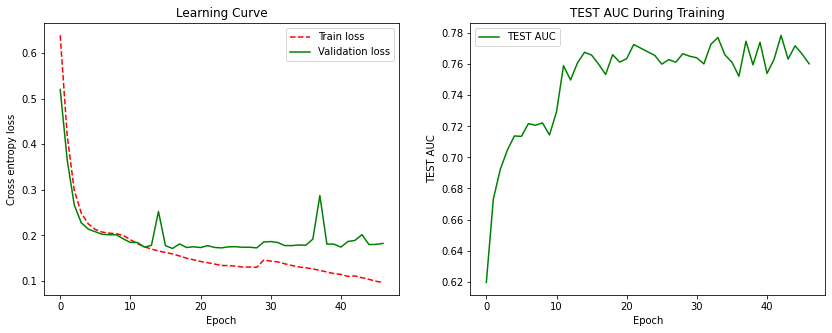


 Test AUC is 0.7600212097167969

 Test AUC in each class is:
(0, 0.7462349766985529)
(1, 0.8206450134616486)
(2, 0.8463141025641026)
(3, 0.7280520618234153)
(4, 0.6600496651365791)
(5, 0.8057595772787318)
(6, 0.7564174107142857)
(7, 0.7489582845638841)
(8, 0.7376011773362765)
(9, 0.6756448568732305)
(10, 0.8601764335223692)
(11, 0.734400269541779)


In [ ]:
# with scheduler
# random split
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM(300,300,300,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0)
model, train_losses, val_losses, test_aucs = train_model_scheduler(model, batch_size=128, optimizer=optimizer, scheduler=scheduler, patience=30, n_epochs=200)

#count_parameters(model)

[ 36/200] Train_Loss: 0.10835 Valid_Loss: 0.19448 Test_AUC: 0.77380
EarlyStopping counter: 30 out of 30
Early Stopping

 Training Time was 401.8135108947754 seconds in cuda:0




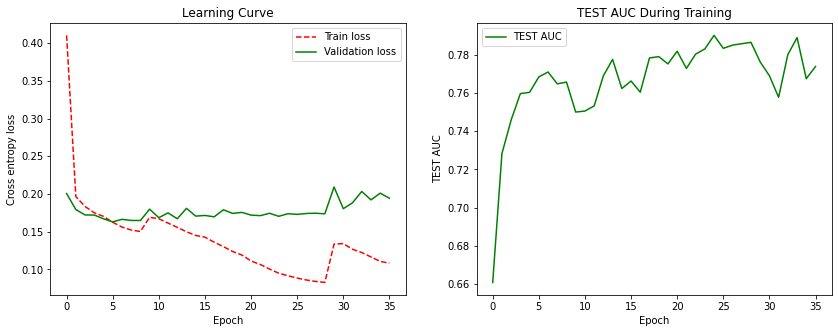


 Test AUC is 0.7683438460032145

 Test AUC in each class is:
(0, 0.7830757910228108)
(1, 0.811823337343186)
(2, 0.8745904558404558)
(3, 0.7480758400600713)
(4, 0.6857551358266235)
(5, 0.846763540290621)
(6, 0.6403459821428571)
(7, 0.7707133604881626)
(8, 0.714103507480991)
(9, 0.7266042780748663)
(10, 0.8638941398865785)
(11, 0.7543800539083558)


In [ ]:
# with scheduler
# random split
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM(300,300,300,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.8)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0)
model, train_losses, val_losses, test_aucs = train_model_scheduler(model, batch_size=128, optimizer=optimizer, scheduler=scheduler, patience=30, n_epochs=200)

#count_parameters(model)

[ 47/200] Train_Loss: 0.08240 Valid_Loss: 0.19248 Test_AUC: 0.78940
EarlyStopping counter: 30 out of 30
Early Stopping

 Training Time was 526.4837372303009 seconds in cuda:0




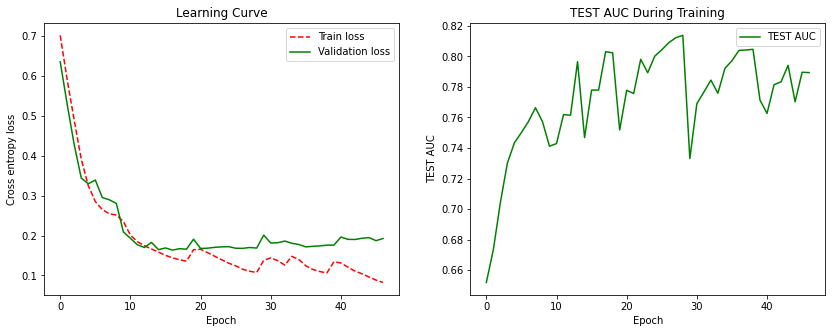


 Test AUC is 0.7779808044433594

 Test AUC in each class is:
(0, 0.7740986019131714)
(1, 0.7558572492409922)
(2, 0.8690349002849003)
(3, 0.772604968399975)
(4, 0.6848069832192039)
(5, 0.7723117569352708)
(6, 0.7366071428571428)
(7, 0.7778454047474131)
(8, 0.8000490556781947)
(9, 0.7483092167348223)
(10, 0.8472432262129804)
(11, 0.7970013477088949)


In [ ]:
# with scheduler
# random split
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM(300,300,300,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=0)
model, train_losses, val_losses, test_aucs = train_model_scheduler(model, batch_size=128, optimizer=optimizer, scheduler=scheduler, patience=30, n_epochs=200)

#count_parameters(model)

[ 50/200] Train_Loss: 0.06024 Valid_Loss: 0.24056 Test_AUC: 0.78310
EarlyStopping counter: 30 out of 30
Early Stopping

 Training Time was 1083.2019946575165 seconds in cuda:0




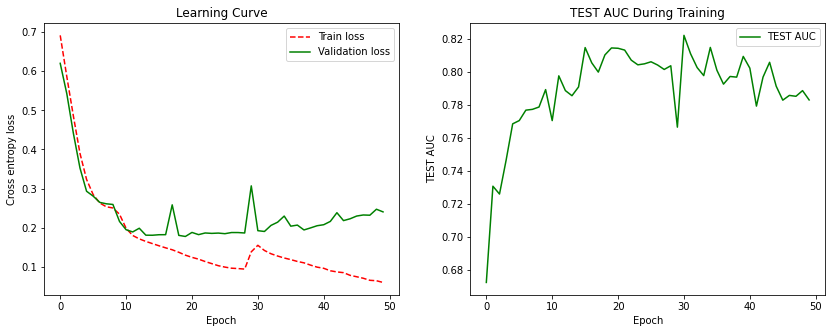


 Test AUC is 0.8146948019663492

 Test AUC in each class is:
(0, 0.8637515570637)
(1, 0.8532358156028368)
(2, 0.8718859265734266)
(3, 0.8271075810003147)
(4, 0.626183712121212)
(5, 0.745917001338688)
(6, 0.7584928229665071)
(7, 0.8088626292466765)
(8, 0.8936983920034767)
(9, 0.8275325410299943)
(10, 0.8903828661208963)
(11, 0.8092871394884817)


In [ ]:
# with scheduler
# random split
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM(300,300,300,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
     
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0)
model, train_losses, val_losses, test_aucs = train_model_scheduler(model, batch_size=128, optimizer=optimizer, scheduler=scheduler, patience=30, n_epochs=200)
 
#count_parameters(model)

[ 24/200] Train_Loss: 0.11271 Valid_Loss: 0.19266 Test_AUC: 0.81929
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 507.83805418014526 seconds in cuda:0




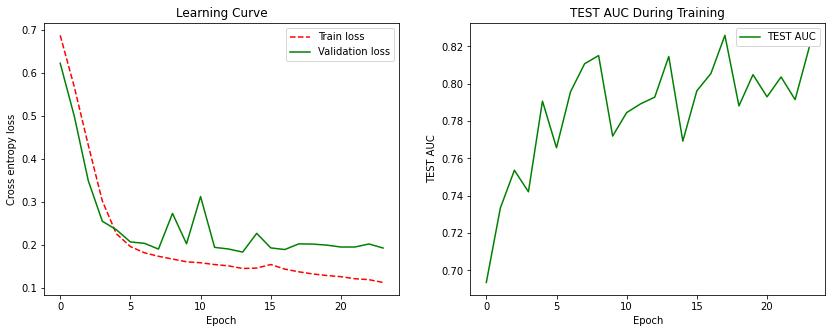


 Test AUC is 0.8146375815073649

 Test AUC in each class is:
(0, 0.7508726003490401)
(1, 0.8394463667820069)
(2, 0.8658925362752865)
(3, 0.7664357959542656)
(4, 0.6427343161311512)
(5, 0.8261666666666666)
(6, 0.8884199134199134)
(7, 0.7720226843100189)
(8, 0.8276862026862027)
(9, 0.864875864875865)
(10, 0.8500023854582464)
(11, 0.88109468386285)


In [ ]:
# random split
# with skipconnections for both edge and node updaters

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM(300,300,300,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=10, n_epochs=200)
#count_parameters(model)

In [ ]:
model_1, train_losses_1, val_losses_1, test_aucs_1

(GNN(
   (GNN1): DGM(
     (linear_0_v): Linear(in_features=163, out_features=300, bias=True)
     (bn_0_v): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (linear_0_e): Linear(in_features=19, out_features=300, bias=True)
     (bn_0_e): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (linear_0_g): Linear(in_features=200, out_features=300, bias=True)
     (bn_0_g): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (linear_e_0): Linear(in_features=2100, out_features=300, bias=True)
     (bn_e_0): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (linear_e_1): Linear(in_features=300, out_features=300, bias=True)
     (bn_e_1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (linear_m_0): Linear(in_features=600, out_features=300, bias=False)
     (bn_m_0): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=T

[ 15/200] Train_Loss: 0.15424 Valid_Loss: 0.30340 Test_AUC: 0.56168
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 234.79178190231323 seconds in cuda:0




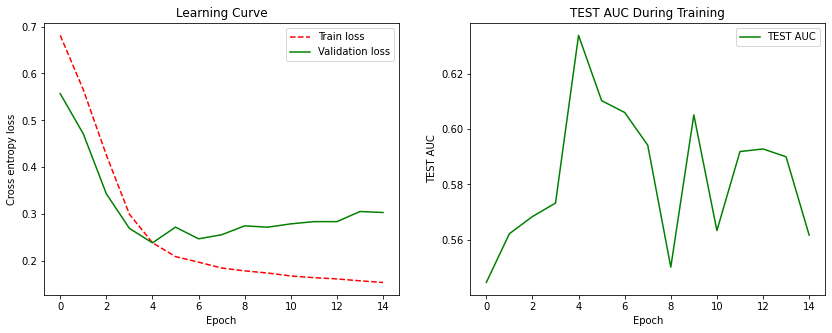


 Test AUC is 0.6340025266011556

 Test AUC in each class is:
(0, 0.7350930773705643)
(1, 0.7730872741253364)
(2, 0.7677995247019727)
(3, 0.7058597185576078)
(4, 0.515563112236026)
(5, 0.544125)
(6, 0.45411255411255413)
(7, 0.5896817895400126)
(8, 0.622049247049247)
(9, 0.49760887260887265)
(10, 0.6530112434598687)
(11, 0.7500393205410507)


In [ ]:
# random split
# with skipconnections for both edge and node updaters
# two layers of one module

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=2)
        #self.GNN2 = DGM(300,300,300,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=2)
        self.linear_1 = nn.Linear(300, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=10, n_epochs=200)
#count_parameters(model)

[ 26/200] Train_Loss: 0.18959 Valid_Loss: 0.63645 Test_AUC: 0.63814
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 975.9755203723907 seconds in cuda:0




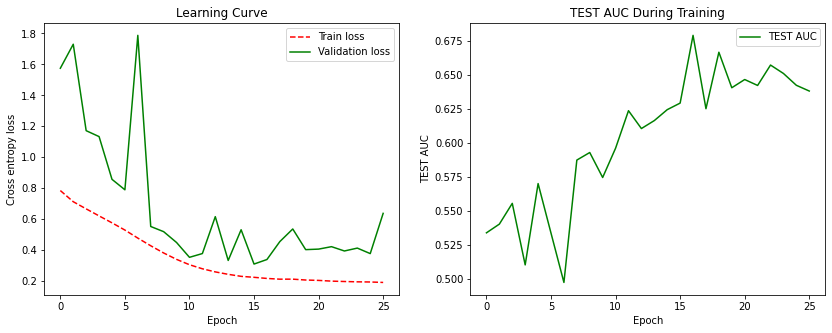


 Test AUC is 0.6292709509531657

 Test AUC in each class is:
(0, 0.6291448516579407)
(1, 0.6226066897347174)
(2, 0.652974476882354)
(3, 0.5654683377308707)
(4, 0.6157814401916648)
(5, 0.7010000000000001)
(6, 0.5739177489177488)
(7, 0.5847826086956522)
(8, 0.6471815221815221)
(9, 0.5782458282458283)
(10, 0.7379653631462603)
(11, 0.642183076439132)


In [ ]:
# random split
# with skipconnections for both edge and node updaters
# two layers for both modules
# batch 32, lr= 0.001

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=2)
        self.GNN2 = DGM(300,300,300,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=2)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)
#count_parameters(model)

[ 26/200] Train_Loss: 0.10790 Valid_Loss: 0.21982 Test_AUC: 0.80019
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 548.6664123535156 seconds in cuda:0




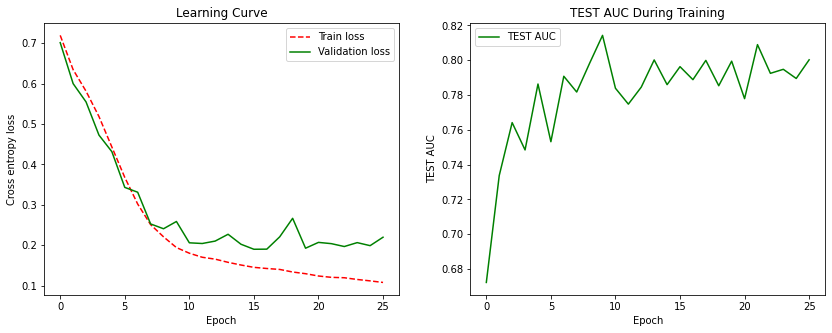


 Test AUC is 0.7962530453999838

 Test AUC in each class is:
(0, 0.711023851076207)
(1, 0.841676278354479)
(2, 0.8486581525204322)
(3, 0.6556728232189973)
(4, 0.6886411499893733)
(5, 0.7828333333333333)
(6, 0.8949134199134199)
(7, 0.7836956521739131)
(8, 0.8245828245828246)
(9, 0.8410663410663411)
(10, 0.8568566021532736)
(11, 0.8254167977351369)


In [ ]:
# random split
# with skipconnections for both edge and node updaters
# batch = 256

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM(300,300,300,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=256, optimizer=optimizer, patience=10, n_epochs=200)
#count_parameters(model)

[ 27/200] Train_Loss: 0.10922 Valid_Loss: 0.21028 Test_AUC: 0.81666
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 669.7770636081696 seconds in cuda:0




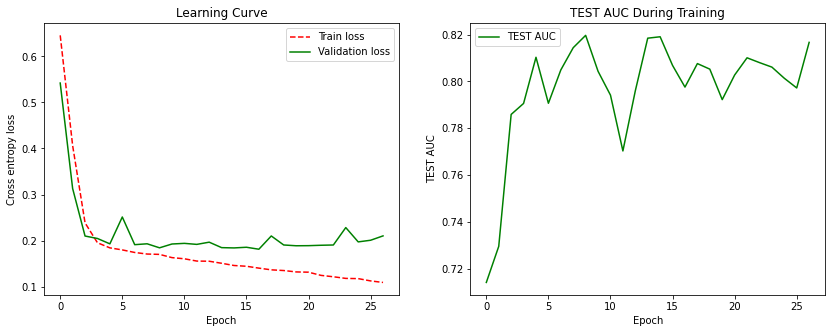


 Test AUC is 0.7975581487019857

 Test AUC in each class is:
(0, 0.6226730657358929)
(1, 0.7934640522875817)
(2, 0.8619123983229321)
(3, 0.7739116094986808)
(4, 0.67142608729254)
(5, 0.801875)
(6, 0.8601731601731601)
(7, 0.7915091367359799)
(8, 0.798026048026048)
(9, 0.8670634920634921)
(10, 0.8604665956330211)
(11, 0.8681975463982384)


In [ ]:
# random split
# with skipconnections for both edge and node updaters
# batch = 64

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM(300,300,300,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=10, n_epochs=200)
#count_parameters(model)

[ 19/200] Train_Loss: 0.16794 Valid_Loss: 0.29123 Test_AUC: 0.65537
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 532.9051587581635 seconds in cuda:0




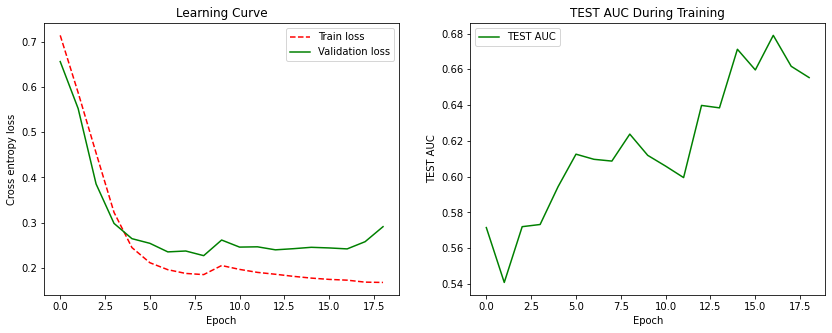


 Test AUC is 0.6237805287043253

 Test AUC in each class is:
(0, 0.6028941244909832)
(1, 0.514801999231065)
(2, 0.6237223950383524)
(3, 0.6963500439753738)
(4, 0.6079757327511255)
(5, 0.6495416666666666)
(6, 0.5925324675324675)
(7, 0.569234404536862)
(8, 0.5273707773707773)
(9, 0.7224257224257223)
(10, 0.7011020817098965)
(11, 0.6774142812205095)


In [ ]:
# random split
# with skipconnections for both edge and node updaters
# two layers for both modules

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=2)
        self.GNN2 = DGM(300,300,300,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=2)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=10, n_epochs=200)
#count_parameters(model)

In [ ]:
model_1, train_losses_1, val_losses_1, test_aucs_1 = model, train_losses, val_losses, test_aucs

[ 20/200] Train_Loss: 0.12958 Valid_Loss: 0.19123 Test_AUC: 0.77587
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 257.81826663017273 seconds in cuda:0




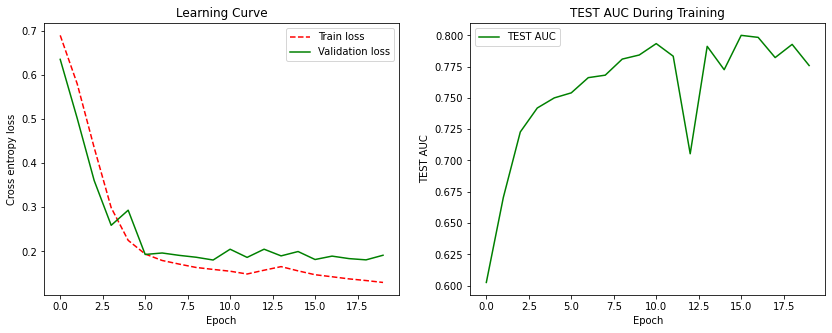


 Test AUC is 0.7842727502187093

 Test AUC in each class is:
(0, 0.6804755614266842)
(1, 0.699547459471845)
(2, 0.8119922630560927)
(3, 0.7898351648351649)
(4, 0.6881728980137085)
(5, 0.8338707140610255)
(6, 0.8494567579313342)
(7, 0.7602199413489735)
(8, 0.8530990936815429)
(9, 0.7667292057535959)
(10, 0.8581832446445626)
(11, 0.8196908105444691)


In [ ]:
# random

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM(300,300,300,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=10, n_epochs=200)
#count_parameters(model)

[ 11/200] Train_Loss: 0.11792 Valid_Loss: 0.18181 Test_AUC: 0.79402
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 152.82669377326965 seconds in cuda:0




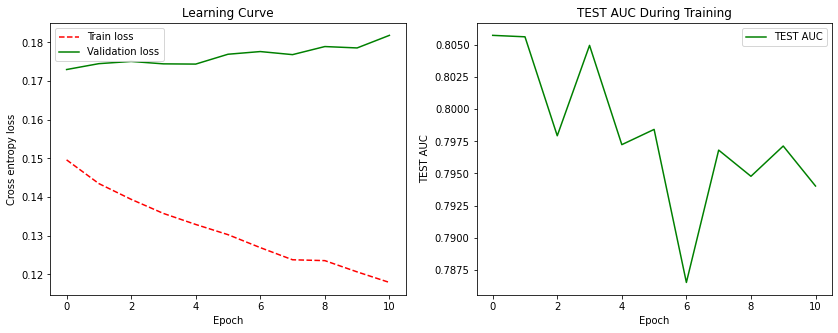


 Test AUC is 0.805740753809611

 Test AUC in each class is:
(0, 0.7178863936591809)
(1, 0.7606690725783354)
(2, 0.8297872340425533)
(3, 0.8322754831375521)
(4, 0.6905265501502839)
(5, 0.8259279647687953)
(6, 0.8773576705780095)
(7, 0.7690322580645161)
(8, 0.8606159529229844)
(9, 0.7910536190382146)
(10, 0.8783599399645245)
(11, 0.8353966494210397)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=10, n_epochs=200)

[ 11/200] Train_Loss: 0.12771 Valid_Loss: 0.17902 Test_AUC: 0.80296
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 181.52585697174072 seconds in cuda:0




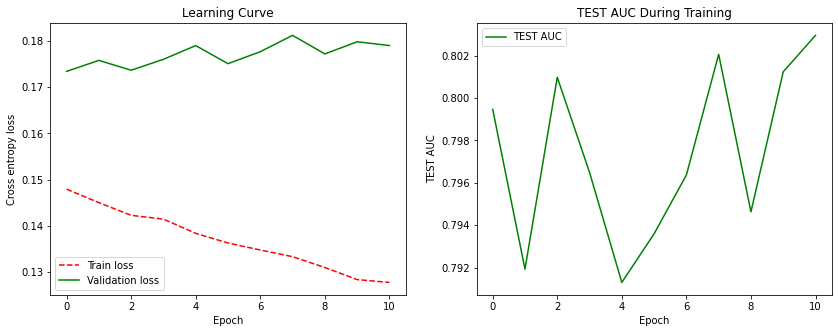


 Test AUC is 0.7994669278462728

 Test AUC in each class is:
(0, 0.7248612945838837)
(1, 0.7333447900555652)
(2, 0.8344294003868472)
(3, 0.8069344448654794)
(4, 0.6966015171514448)
(5, 0.8245517458320225)
(6, 0.8591047370708388)
(7, 0.7727565982404692)
(8, 0.8663717194278597)
(9, 0.7720614857970443)
(10, 0.8767055532814846)
(11, 0.825880758807588)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[ 31/200] Train_Loss: 0.12539 Valid_Loss: 0.18871 Test_AUC: 0.79991
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 408.53822112083435 seconds in cuda:0




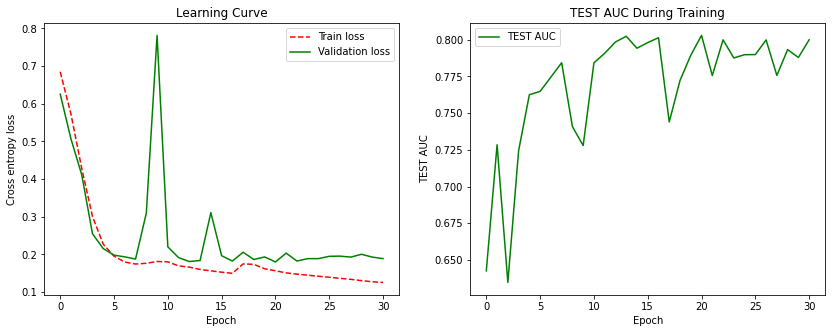


 Test AUC is 0.8029356002807617

 Test AUC in each class is:
(0, 0.7821928665785998)
(1, 0.7469782895113708)
(2, 0.8053421755549415)
(3, 0.827728306176582)
(4, 0.7322720694645442)
(5, 0.8070934256055363)
(6, 0.8192090395480226)
(7, 0.7656304985337241)
(8, 0.8668442077230359)
(9, 0.7905269740956519)
(10, 0.8589081047891935)
(11, 0.8325018477457502)


In [ ]:
# random

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM(300,300,300,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=10, n_epochs=200)
#count_parameters(model)

[ 15/200] Train_Loss: 0.12378 Valid_Loss: 0.18468 Test_AUC: 0.80554
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 194.29767775535583 seconds in cuda:0




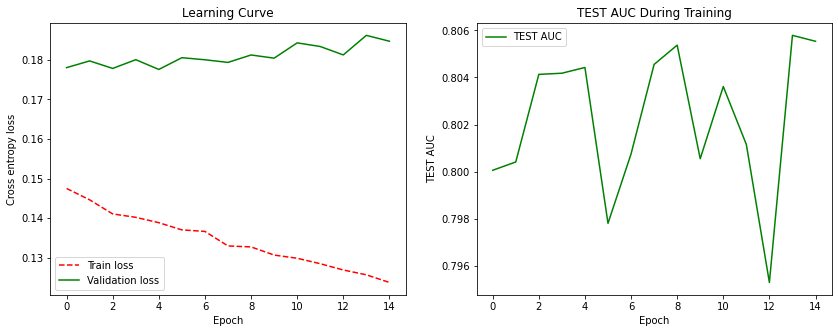


 Test AUC is 0.8044255574544271

 Test AUC in each class is:
(0, 0.7631704095112285)
(1, 0.7138110786503981)
(2, 0.8118448926959565)
(3, 0.832701780977643)
(4, 0.7286938820947504)
(5, 0.8247483485372759)
(6, 0.8066927422859627)
(7, 0.7844721407624633)
(8, 0.877110089772776)
(9, 0.8059971692834337)
(10, 0.8630781825624232)
(11, 0.8407859078590786)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=10, n_epochs=200)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=10, n_epochs=200)

[  7/200] Train_Loss: 0.14035 Valid_Loss: 0.18249 Test_AUC: 0.80367
EarlyStopping counter: 5 out of 10


KeyboardInterrupt: ignored

In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.GNN3 = DGM(200,200,200,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN2(mol_dgl_graph, fg)
      output = self.GNN3(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=10, n_epochs=200)
count_parameters(model)

KeyboardInterrupt: ignored

[ 21/200] Train_Loss: 0.11760 Valid_Loss: 0.29693 Test_AUC: 0.71142
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 445.09303045272827 seconds in cuda:0




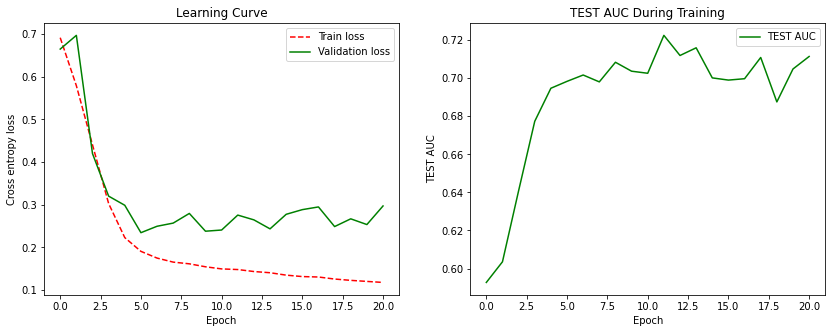


 Test AUC is 0.6983452637990316
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |   48900    |
|    GNN1.linear_0_v.bias    |    300     |
|     GNN1.bn_0_v.weight     |    300     |
|      GNN1.bn_0_v.bias      |    300     |
|   GNN1.linear_0_e.weight   |    5700    |
|    GNN1.linear_0_e.bias    |    300     |
|     GNN1.bn_0_e.weight     |    300     |
|      GNN1.bn_0_e.bias      |    300     |
|   GNN1.linear_0_g.weight   |   60000    |
|    GNN1.linear_0_g.bias    |    300     |
|     GNN1.bn_0_g.weight     |    300     |
|      GNN1.bn_0_g.bias      |    300     |
|   GNN1.linear_e_0.weight   |   540000   |
|    GNN1.linear_e_0.bias    |    300     |
|     GNN1.bn_e_0.weight     |    300     |
|      GNN1.bn_e_0.bias      |    300     |
|   GNN1.linear_e_1.weight   |   90000    |
|    GNN1.linear_e_1.bias    |    300     |
|     GNN1.bn_e_1.weight     |    300     |

2026422

In [ ]:
# scafold

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM(300,300,300,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
count_parameters(model)

In [ ]:
# scafold

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.GNN3 = DGM(200,200,200,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN2(mol_dgl_graph, fg)
      output = self.GNN3(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=10, n_epochs=200)
count_parameters(model)

[ 10/200] Train_Loss: 0.15953 Valid_Loss: 0.38978 Test_AUC: 0.66973
EarlyStopping counter: 1 out of 10


[ 34/200] Train_Loss: 0.08655 Valid_Loss: 0.39922 Test_AUC: 0.69271
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 4071.3076980113983 seconds in cpu




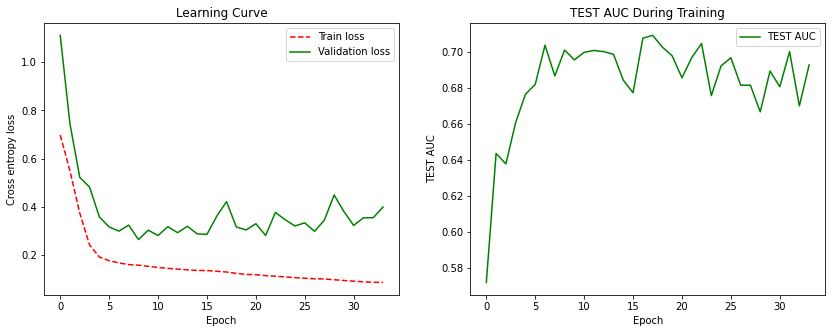


 Test AUC is 0.7009362379709879
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |   48900    |
|    GNN1.linear_0_v.bias    |    300     |
|     GNN1.bn_0_v.weight     |    300     |
|      GNN1.bn_0_v.bias      |    300     |
|   GNN1.linear_0_e.weight   |    5700    |
|    GNN1.linear_0_e.bias    |    300     |
|     GNN1.bn_0_e.weight     |    300     |
|      GNN1.bn_0_e.bias      |    300     |
|   GNN1.linear_0_g.weight   |   60000    |
|    GNN1.linear_0_g.bias    |    300     |
|     GNN1.bn_0_g.weight     |    300     |
|      GNN1.bn_0_g.bias      |    300     |
|   GNN1.linear_e_0.weight   |   540000   |
|    GNN1.linear_e_0.bias    |    300     |
|     GNN1.bn_e_0.weight     |    300     |
|      GNN1.bn_e_0.bias      |    300     |
|   GNN1.linear_e_1.weight   |   90000    |
|    GNN1.linear_e_1.bias    |    300     |
|     GNN1.bn_e_1.weight     |    300     |

2908477

In [ ]:
# scafold

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.GNN3 = DGM(200,200,200,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN2(mol_dgl_graph, fg)
      output = self.GNN3(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=10, n_epochs=200)
count_parameters(model)

[ 23/200] Train_Loss: 0.10349 Valid_Loss: 0.28658 Test_AUC: 0.69722
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 479.1041347980499 seconds in cuda:0




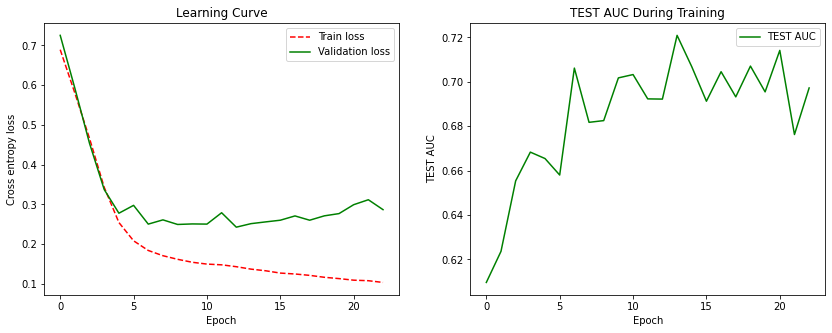


 Test AUC is 0.6922018527984619
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |   32600    |
|    GNN1.linear_0_v.bias    |    200     |
|     GNN1.bn_0_v.weight     |    200     |
|      GNN1.bn_0_v.bias      |    200     |
|   GNN1.linear_0_e.weight   |    3800    |
|    GNN1.linear_0_e.bias    |    200     |
|     GNN1.bn_0_e.weight     |    200     |
|      GNN1.bn_0_e.bias      |    200     |
|   GNN1.linear_0_g.weight   |   40000    |
|    GNN1.linear_0_g.bias    |    200     |
|     GNN1.bn_0_g.weight     |    200     |
|      GNN1.bn_0_g.bias      |    200     |
|   GNN1.linear_e_0.weight   |   240000   |
|    GNN1.linear_e_0.bias    |    200     |
|     GNN1.bn_e_0.weight     |    200     |
|      GNN1.bn_e_0.bias      |    200     |
|   GNN1.linear_e_1.weight   |   40000    |
|    GNN1.linear_e_1.bias    |    200     |
|     GNN1.bn_e_1.weight     |    200     |

1052772

In [ ]:
# scafold

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.GNN2 = DGM(200,200,200,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 30)
        self.linear_2 = nn.Linear(30, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(30)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=10, n_epochs=200)
count_parameters(model)

[ 38/200] Train_Loss: 0.07388 Valid_Loss: 0.37463 Test_AUC: 0.69512
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 1963.6186969280243 seconds in cpu




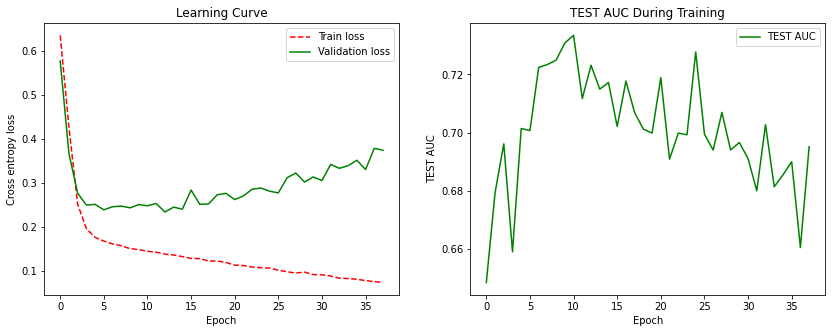


 Test AUC is 0.7231431802113851


ValueError: ignored

In [ ]:
# scafold

seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.GNN2 = DGM(200,200,200,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 30)
        self.linear_2 = nn.Linear(30, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(30)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 43/200] Train_Loss: 0.07374 Valid_Loss: 0.23689 Test_AUC: 0.76532
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 635.811282157898 seconds in cuda:0




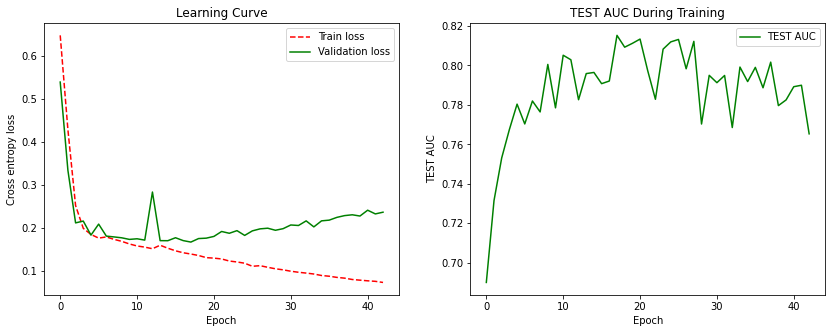


 Test AUC is 0.8152149518330892
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    5800    |
|    GNN1.linear_0_v.bias    |    200     |
|     GNN1.bn_0_v.weight     |    200     |
|      GNN1.bn_0_v.bias      |    200     |
|   GNN1.linear_0_e.weight   |    3800    |
|    GNN1.linear_0_e.bias    |    200     |
|     GNN1.bn_0_e.weight     |    200     |
|      GNN1.bn_0_e.bias      |    200     |
|   GNN1.linear_0_g.weight   |   40000    |
|    GNN1.linear_0_g.bias    |    200     |
|     GNN1.bn_0_g.weight     |    200     |
|      GNN1.bn_0_g.bias      |    200     |
|   GNN1.linear_e_0.weight   |   240000   |
|    GNN1.linear_e_0.bias    |    200     |
|     GNN1.bn_e_0.weight     |    200     |
|      GNN1.bn_e_0.bias      |    200     |
|   GNN1.linear_e_1.weight   |   40000    |
|    GNN1.linear_e_1.bias    |    200     |
|     GNN1.bn_e_1.weight     |    200     |

1424764

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.GNN2 = GGNN(200,200,200,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 30)
        self.linear_2 = nn.Linear(30, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(30)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 40/200] Train_Loss: 0.06780 Valid_Loss: 0.23896 Test_AUC: 0.76286
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 690.1003220081329 seconds in cuda:0




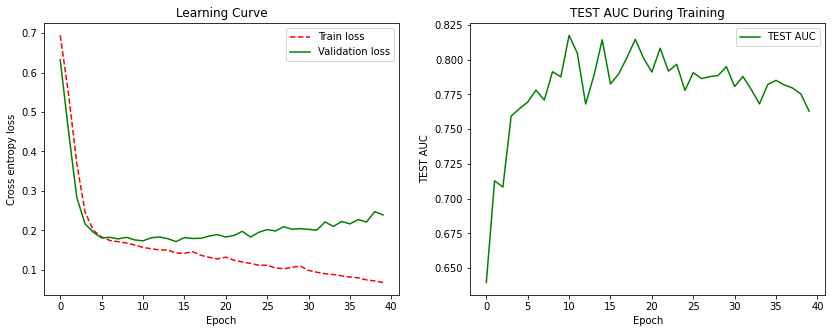


 Test AUC is 0.8141297499338785
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |   48900    |
|    GNN1.linear_0_v.bias    |    300     |
|     GNN1.bn_0_v.weight     |    300     |
|      GNN1.bn_0_v.bias      |    300     |
|   GNN1.linear_0_e.weight   |    5700    |
|    GNN1.linear_0_e.bias    |    300     |
|     GNN1.bn_0_e.weight     |    300     |
|      GNN1.bn_0_e.bias      |    300     |
|   GNN1.linear_0_g.weight   |   60000    |
|    GNN1.linear_0_g.bias    |    300     |
|     GNN1.bn_0_g.weight     |    300     |
|      GNN1.bn_0_g.bias      |    300     |
|   GNN1.linear_e_0.weight   |   540000   |
|    GNN1.linear_e_0.bias    |    300     |
|     GNN1.bn_e_0.weight     |    300     |
|      GNN1.bn_e_0.bias      |    300     |
|   GNN1.linear_e_1.weight   |   90000    |
|    GNN1.linear_e_1.bias    |    300     |
|     GNN1.bn_e_1.weight     |    300     |

4026065

In [ ]:
# with cat
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = GGNN(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.GNN3 = GGNN(200,200,200,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN1(mol_dgl_graph,fg)
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN2(mol_dgl_graph, fg)
      output = self.GNN3(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

In [ ]:
ls '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/

/bin/bash: -c: line 0: unexpected EOF while looking for matching `''
/bin/bash: -c: line 1: syntax error: unexpected end of file


[ 34/200] Train_Loss: 0.14375 Valid_Loss: 0.26322 Test_AUC: 0.56714
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 617.3115365505219 seconds in cpu




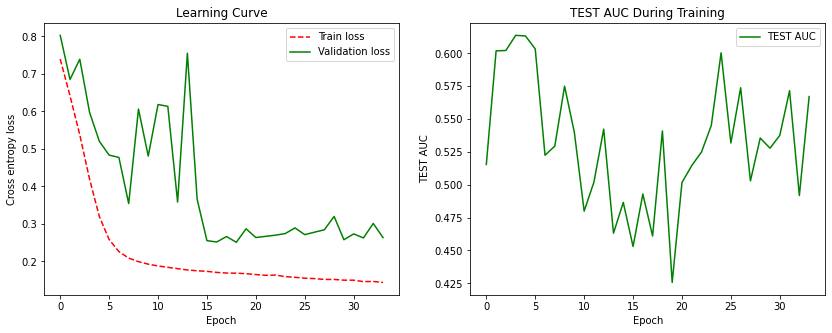


 Test AUC is 0.5410401821136475


In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,40,40,40,40,40,40,40,40, num_layers=2)
        # self.GNN2 = DGM(100,100,100,200,200,200,200,200,200,200,200, num_layers=1)
        # self.GNN3 = DGM(200,200,200,300,300,300,300,300,300,300,300, num_layers=1)
        self.linear_1 = nn.Linear(40, 20)
        self.linear_2 = nn.Linear(20, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(20)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN2(mol_dgl_graph, fg)
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
#count_parameters(model)

[ 23/200] Train_Loss: 0.16667 Valid_Loss: 0.30895 Test_AUC: 0.54089
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 436.9839370250702 seconds in cpu




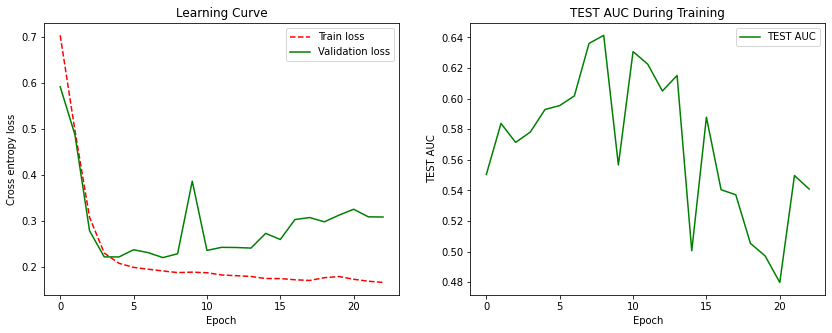


 Test AUC is 0.636067787806193


In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,40,40,40,40,40,40,40,40, num_layers=2)
        # self.GNN2 = DGM(100,100,100,200,200,200,200,200,200,200,200, num_layers=1)
        # self.GNN3 = DGM(200,200,200,300,300,300,300,300,300,300,300, num_layers=1)
        self.linear_1 = nn.Linear(40, 20)
        self.linear_2 = nn.Linear(20, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(20)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN2(mol_dgl_graph, fg)
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=15, n_epochs=200)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
#count_parameters(model)

In [ ]:
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=32, optimizer=optimizer, patience=15, n_epochs=200)

[  5/200] Train_Loss: 0.18377 Valid_Loss: 0.35258 Test_AUC: 0.62100
EarlyStopping counter: 3 out of 15


KeyboardInterrupt: ignored

[ 41/200] Train_Loss: 0.14113 Valid_Loss: 0.26135 Test_AUC: 0.56070
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 712.3061482906342 seconds in cpu




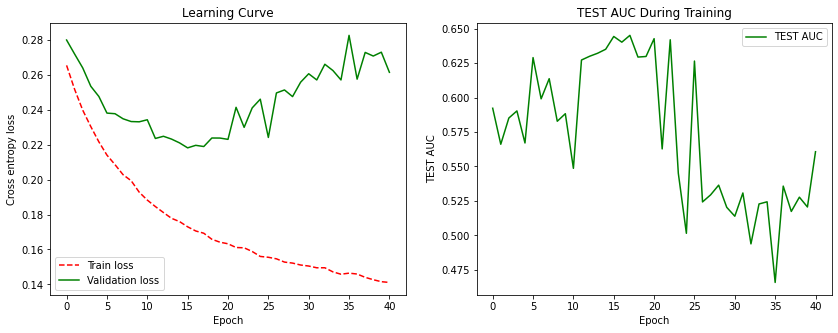


 Test AUC is 0.6443134546279907
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    4890    |
|    GNN1.linear_0_v.bias    |     30     |
|     GNN1.bn_0_v.weight     |     30     |
|      GNN1.bn_0_v.bias      |     30     |
|   GNN1.linear_0_e.weight   |    570     |
|    GNN1.linear_0_e.bias    |     30     |
|     GNN1.bn_0_e.weight     |     30     |
|      GNN1.bn_0_e.bias      |     30     |
|   GNN1.linear_0_g.weight   |    6000    |
|    GNN1.linear_0_g.bias    |     30     |
|     GNN1.bn_0_g.weight     |     30     |
|      GNN1.bn_0_g.bias      |     30     |
|   GNN1.linear_e_0.weight   |    5400    |
|    GNN1.linear_e_0.bias    |     30     |
|     GNN1.bn_e_0.weight     |     30     |
|      GNN1.bn_e_0.bias      |     30     |
|   GNN1.linear_e_1.weight   |    900     |
|    GNN1.linear_e_1.bias    |     30     |
|     GNN1.bn_e_1.weight     |     30     |

29612

In [ ]:
seed_value= 100 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

# Test without BN before alpha updater
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,30,30,30,30,30,30,30,30,30,1,30,30,num_layers=2)
        self.linear_1 = nn.Linear(30, 15)
        self.linear_2 = nn.Linear(15, 12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = nn.BatchNorm1d(15, affine=False)(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, _ = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=10)
model, train_losses, val_losses, _ = train_model(model, batch_size=32, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

In [ ]:
model=DGM(163,19,200,2,2,2,2,2,2,2,2,2,num_layers=3)

In [ ]:
 a =torch.Tensor([[1,2],[3,4]])
 b =torch.Tensor([2,2])
 torch.mul(a, b.view(-1,1))

tensor([[2., 4.],
        [6., 8.]])

In [ ]:
# checking over smoothing
model.eval()
au_i_std_mean = 0
nf_std_mean = 0
ef_std_mean = 0
alpha_std_mean = 0
au_i_std_mean_list = []
length = 0
_, _, test_dataloader = loader(1)
for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
   mol_dgl_graph=mol_dgl_graph.to(device)
   fg=fg.to(device)
   out = model(mol_dgl_graph, fg)
   #au_i_std_mean += torch.std(out[3], 0).mean().item()
   #au_i_std_mean_list.append(torch.std(out[3], 0).mean().item())
   nf_std_mean += torch.std(out[1], 0).mean().item()
   ef_std_mean += torch.std(out[2], 0).mean().item()
   alpha_std_mean += out[-1][-1].std().item()
   length += 1
   break
  #  if i == 0:
  #    break
     
#print('\n', nf_std_mean/length,'\n',ef_std_mean/length)#, '\n\n Alpha: \n')#,au_i_std_mean/length,'\n',alpha_std_mean/length,)

# _, _, test_dataloader = loader(700)
# for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
#    mol_dgl_graph=mol_dgl_graph.to(device)
#    fg=fg.to(device)
#    out = model.GNN1(mol_dgl_graph, fg)
# print('\n', torch.mean(out[1],0),torch.std(out[1], 0),torch.std(out[1], 0).mean())
# print('\n', torch.mean(out[2],0),torch.std(out[2], 0),torch.std(out[2], 0).mean())
# print('\n', torch.mean(out[3],0),torch.std(out[3], 0),torch.std(out[3], 0).mean())
# #print('\n', torch.mean(out[4],0),torch.std(out[4], 0),torch.std(out[4], 0).mean())

In [ ]:
# checking over smoothing
model.eval()
au_i_std_mean = 0
nf_std_mean = 0
ef_std_mean = 0
alpha_std_mean = 0
au_i_std_mean_list = []
length = 0
_, _, test_dataloader = loader(1)
for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
   mol_dgl_graph=mol_dgl_graph.to(device)
   fg=fg.to(device)
   out = model.GNN1(mol_dgl_graph, fg)
   #au_i_std_mean += torch.std(out[3], 0).mean().item()
   #au_i_std_mean_list.append(torch.std(out[3], 0).mean().item())
   nf_std_mean += torch.std(out[1], 0).mean().item()
   ef_std_mean += torch.std(out[2], 0).mean().item()
   alpha_std_mean += out[-1][-1].std().item()
   length += 1
  #  if i == 0:
  #    break
print('\n', nf_std_mean/length,'\n',ef_std_mean/length)#, '\n\n Alpha: \n')#,au_i_std_mean/length,'\n',alpha_std_mean/length,)

# _, _, test_dataloader = loader(700)
# for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
#    mol_dgl_graph=mol_dgl_graph.to(device)
#    fg=fg.to(device)
#    out = model.GNN1(mol_dgl_graph, fg)
# print('\n', torch.mean(out[1],0),torch.std(out[1], 0),torch.std(out[1], 0).mean())
# print('\n', torch.mean(out[2],0),torch.std(out[2], 0),torch.std(out[2], 0).mean())
# print('\n', torch.mean(out[3],0),torch.std(out[3], 0),torch.std(out[3], 0).mean())
# #print('\n', torch.mean(out[4],0),torch.std(out[4], 0),torch.std(out[4], 0).mean())

AttributeError: ignored

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.GNN2 = GGNN(200,200,200,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 30)
        self.linear_2 = nn.Linear(30, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(30)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,300,300,300,300,300,300,300,300,300, num_layers=1)
        self.GNN2 = DGM(300,300,300,200,200,200,200,200,200,200,200,200, num_layers=1)
        self.GNN3 = DGM(200,200,200,100,100,100,100,100,100,100,100,100, num_layers=1)
        self.linear_1 = nn.Linear(100, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN2(mol_dgl_graph, fg)
      output = self.GNN3(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=10, n_epochs=200)
#count_parameters(model)

In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,300,300,300,300,300,300,300,300,300, num_layers=1)
        self.GNN2 = DGM(300,300,300,200,200,200,200,200,200,200,200,200, num_layers=1)
        self.GNN3 = DGM(200,200,200,100,100,100,100,100,100,100,100,100, num_layers=1)
        self.linear_1 = nn.Linear(100, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN1(mol_dgl_graph,fg)
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN2(mol_dgl_graph, fg)
      output = self.GNN3(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=10, n_epochs=200)
#count_parameters(model)

[ 33/200] Train_Loss: 0.08796 Valid_Loss: 0.22155 Test_AUC: 0.78563
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 568.2829356193542 seconds in cuda:0




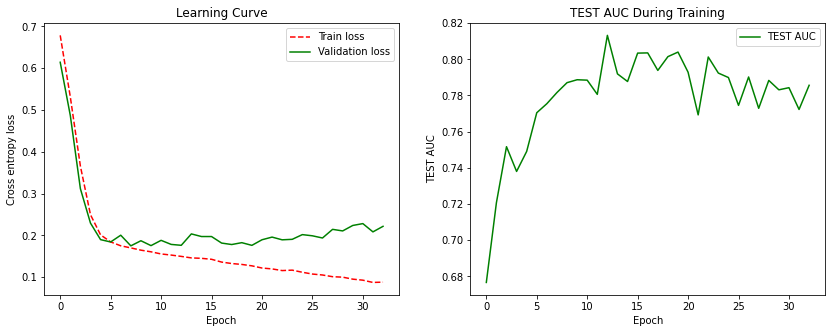


 Test AUC is 0.781628688176473


In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = DGM(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.GNN3 = DGM(200,200,200,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN1(mol_dgl_graph,fg)
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN2(mol_dgl_graph, fg)
      output = self.GNN3(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=25, n_epochs=200)
#count_parameters(model)

[ 27/200] Train_Loss: 0.10548 Valid_Loss: 0.21629 Test_AUC: 0.79967
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 460.7196755409241 seconds in cuda:0




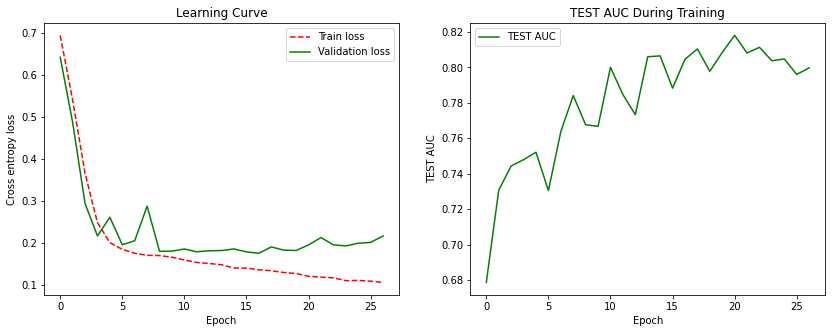


 Test AUC is 0.8045189380645752


In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,300,300,300,300,300,300,300,300,300, num_layers=1)
        self.GNN2 = DGM(300,300,300,200,200,200,200,200,200,200,200,200, num_layers=1)
        self.GNN3 = DGM(200,200,200,100,100,100,100,100,100,100,100,100, num_layers=1)
        self.linear_1 = nn.Linear(100, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN1(mol_dgl_graph,fg)
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN2(mol_dgl_graph, fg)
      output = self.GNN3(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=10, n_epochs=200)
#count_parameters(model)

[ 19/200] Train_Loss: 0.10739 Valid_Loss: 0.19487 Test_AUC: 0.78275
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 320.7157666683197 seconds in cuda:0




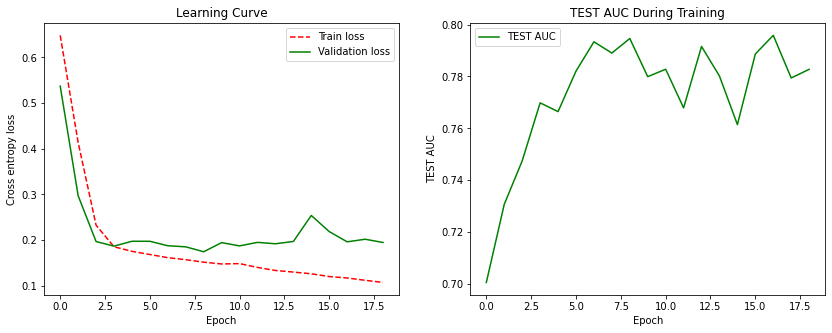


 Test AUC is 0.7946391105651855


In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,100,100,100,100,100,100, 100,100, num_layers=1)
        self.GNN2 = DGM(100,100,100,200,200,200,200,200,200,200,200, num_layers=1)
        self.GNN3 = DGM(200,200,200,300,300,300,300,300,300,300,300, num_layers=1)
        self.linear_1 = nn.Linear(300, 200)
        self.linear_2 = nn.Linear(200, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(200)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN2(mol_dgl_graph, fg)
      output = self.GNN3(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=10, n_epochs=200)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
#count_parameters(model)

[ 22/200] Train_Loss: 0.11157 Valid_Loss: 0.35018 Test_AUC: 0.51385
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 246.35384702682495 seconds in cuda:0




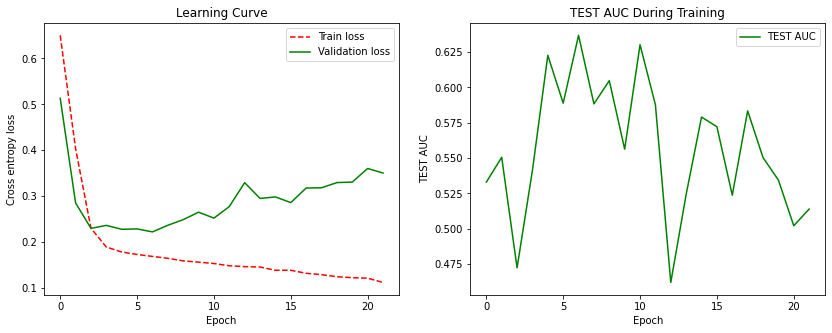


 Test AUC is 0.6369436184565226


In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,400,400,400,400,400,400,400,400, num_layers=3)
        # self.GNN2 = DGM(100,100,100,200,200,200,200,200,200,200,200, num_layers=1)
        # self.GNN3 = DGM(200,200,200,300,300,300,300,300,300,300,300, num_layers=1)
        self.linear_1 = nn.Linear(400, 200)
        self.linear_2 = nn.Linear(200, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(200)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN2(mol_dgl_graph, fg)
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
#count_parameters(model)

[ 14/200] Train_Loss: 0.14380 Valid_Loss: 0.28129 Test_AUC: 0.53153
EarlyStopping counter: 10 out of 10
Early Stopping

 Training Time was 149.56637048721313 seconds in cuda:0




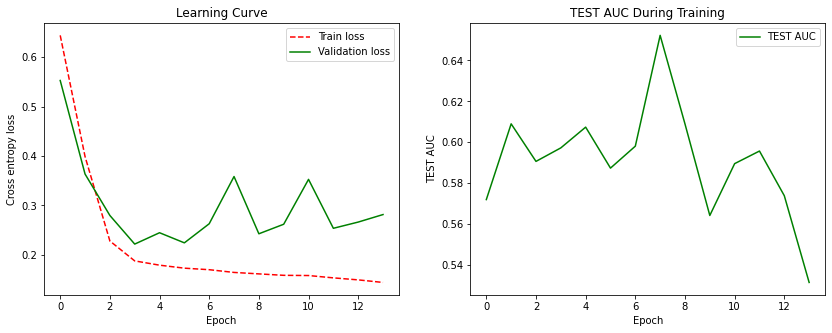


 Test AUC is 0.5972563425699869


In [ ]:
# with cat_s
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,400,400,400,400,400,400,400,400, num_layers=3)
        # self.GNN2 = DGM(100,100,100,200,200,200,200,200,200,200,200, num_layers=1)
        # self.GNN3 = DGM(200,200,200,300,300,300,300,300,300,300,300, num_layers=1)
        self.linear_1 = nn.Linear(400, 200)
        self.linear_2 = nn.Linear(200, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(200)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN2(mol_dgl_graph, fg)
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=10, n_epochs=200)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
#count_parameters(model)

[ 18/200] Train_Loss: 0.12216 Valid_Loss: 0.31684 Test_AUC: 0.60209
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 160.57030987739563 seconds in cuda:0




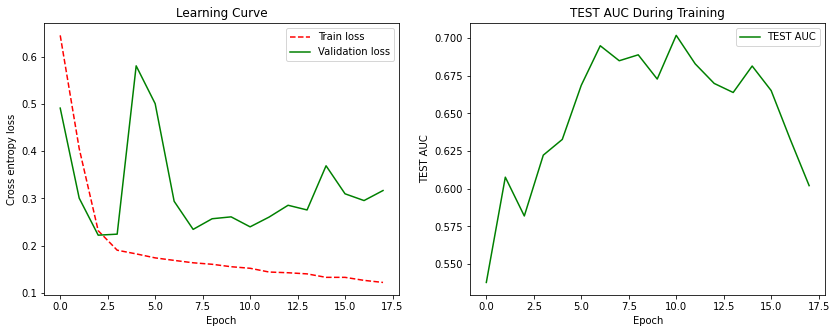


 Test AUC is 0.5819743474324545


In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,400,400,400,400,400,400,400,400, num_layers=2)
        # self.GNN2 = DGM(100,100,100,200,200,200,200,200,200,200,200, num_layers=1)
        # self.GNN3 = DGM(200,200,200,300,300,300,300,300,300,300,300, num_layers=1)
        self.linear_1 = nn.Linear(400, 200)
        self.linear_2 = nn.Linear(200, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(200)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN2(mol_dgl_graph, fg)
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
#count_parameters(model)

[ 33/200] Train_Loss: 0.14916 Valid_Loss: 0.31336 Test_AUC: 0.54710
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 231.66725754737854 seconds in cuda:0




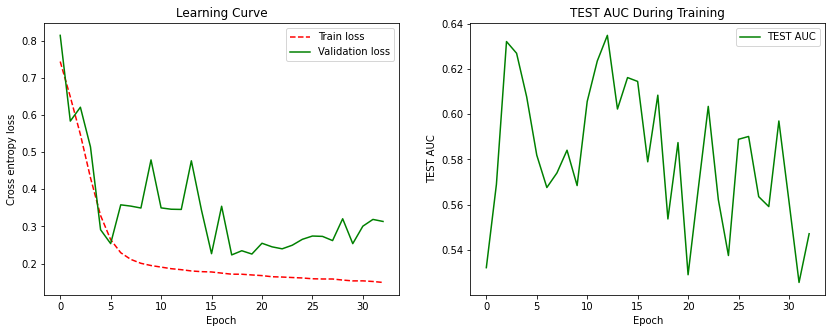


 Test AUC is 0.6084059874216715


In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,40,40,40,40,40,40,40,40, num_layers=2)
        # self.GNN2 = DGM(100,100,100,200,200,200,200,200,200,200,200, num_layers=1)
        # self.GNN3 = DGM(200,200,200,300,300,300,300,300,300,300,300, num_layers=1)
        self.linear_1 = nn.Linear(40, 20)
        self.linear_2 = nn.Linear(20, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(20)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN2(mol_dgl_graph, fg)
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
#count_parameters(model)

[ 23/200] Train_Loss: 0.08744 Valid_Loss: 0.24114 Test_AUC: 0.75704
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 150.04007196426392 seconds in cuda:0




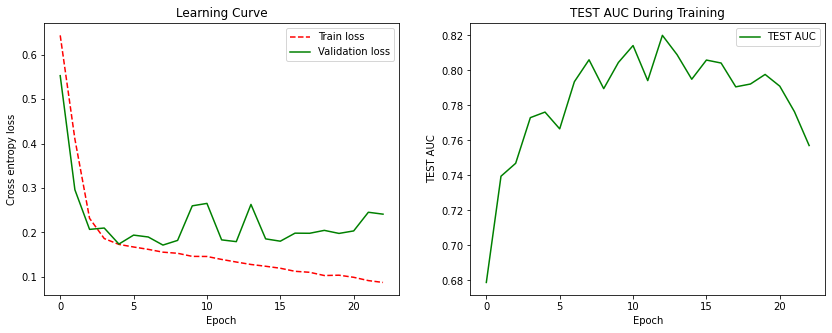


 Test AUC is 0.806028683980306


In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,400,400,400,400,400,400,400,400, num_layers=1)
        # self.GNN2 = DGM(100,100,100,200,200,200,200,200,200,200,200, num_layers=1)
        # self.GNN3 = DGM(200,200,200,300,300,300,300,300,300,300,300, num_layers=1)
        self.linear_1 = nn.Linear(400, 200)
        self.linear_2 = nn.Linear(200, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(200)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      #(fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN2(mol_dgl_graph, fg)
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
#count_parameters(model)

[ 28/200] Train_Loss: 0.07820 Valid_Loss: 0.23272 Test_AUC: 0.78513
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 501.99456000328064 seconds in cuda:0




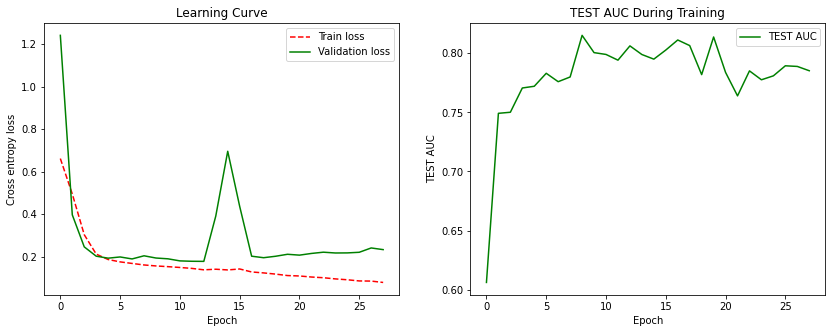


 Test AUC is 0.8061250845591227


In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,100,100,100,100,100,100, 100,100, num_layers=1)
        self.GNN2 = DGM(100,100,100,200,200,200,200,200,200,200,200, num_layers=1)
        self.GNN3 = DGM(200,200,200,300,300,300,300,300,300,300,300, num_layers=1)
        self.linear_1 = nn.Linear(300, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN1(mol_dgl_graph,fg)
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN2(mol_dgl_graph, fg)
      output = self.GNN3(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
#count_parameters(model)

[ 28/200] Train_Loss: 0.06145 Valid_Loss: 0.22872 Test_AUC: 0.73968
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 499.37360405921936 seconds in cuda:0




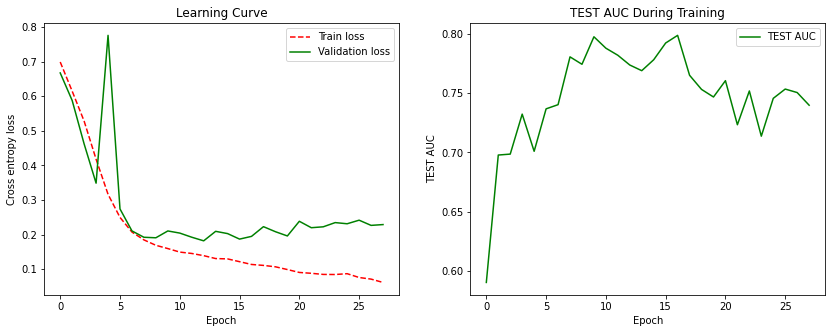


 Test AUC is 0.7735403378804525


In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,100,100,100,100,100,100, 100,100, num_layers=1)
        self.GNN2 = DGM(100,100,100,200,200,200,200,200,200,200,200, num_layers=1)
        self.GNN3 = DGM(200,200,200,300,300,300,300,300,300,300,300, num_layers=1)
        self.linear_1 = nn.Linear(300, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN1(mol_dgl_graph,fg)
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN2(mol_dgl_graph, fg)
      output = self.GNN3(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=256, optimizer=optimizer, patience=15, n_epochs=200)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
#count_parameters(model)

[ 25/200] Train_Loss: 0.09840 Valid_Loss: 0.20265 Test_AUC: 0.77253
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 449.42795157432556 seconds in cuda:0




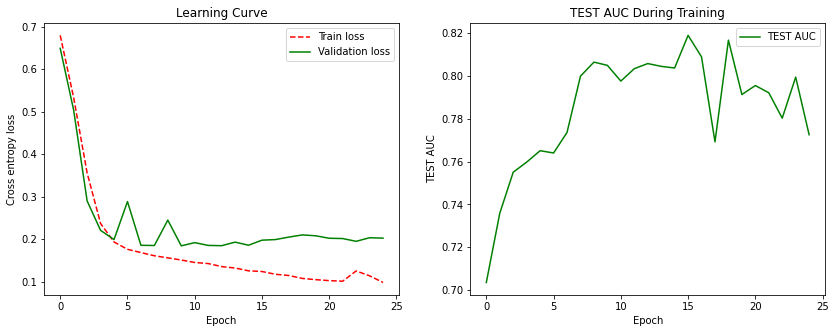


 Test AUC is 0.804975668589274


In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,100,100,100,100,100,100,100,100, num_layers=1)
        self.GNN2 = DGM(100,100,100,200,200,200,200,200,200,200,200, num_layers=1)
        self.GNN3 = DGM(200,200,200,300,300,300,300,300,300,300,300, num_layers=1)
        self.linear_1 = nn.Linear(300, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN1(mol_dgl_graph,fg)
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN2(mol_dgl_graph, fg)
      output = self.GNN3(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
#count_parameters(model)

[ 26/200] Train_Loss: 0.08921 Valid_Loss: 0.21131 Test_AUC: 0.77073
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 330.92865920066833 seconds in cuda:0




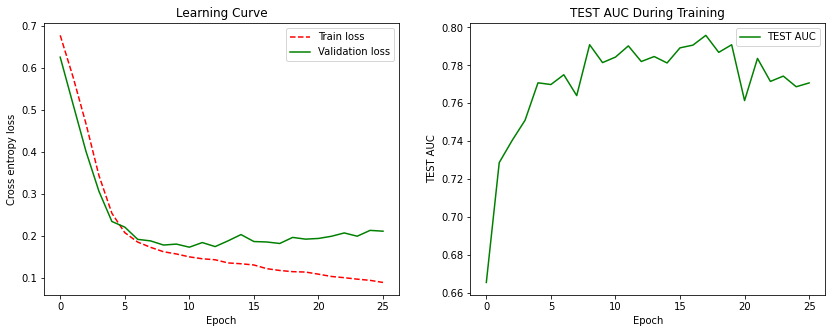


 Test AUC is 0.7843403021494547


ValueError: ignored

In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,200,200,200,200,200,200,200,200,num_layers=2)
        self.GNN2 = DGM(200,200,200,100,100,100,100,100,100,100,100,num_layers=2)
        self.linear_1 = nn.Linear(100, 30)
        self.linear_2 = nn.Linear(30, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(30)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _,_) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
count_parameters(model)

[ 26/200] Train_Loss: 0.09006 Valid_Loss: 0.22581 Test_AUC: 0.78812
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 332.0936098098755 seconds in cuda:0




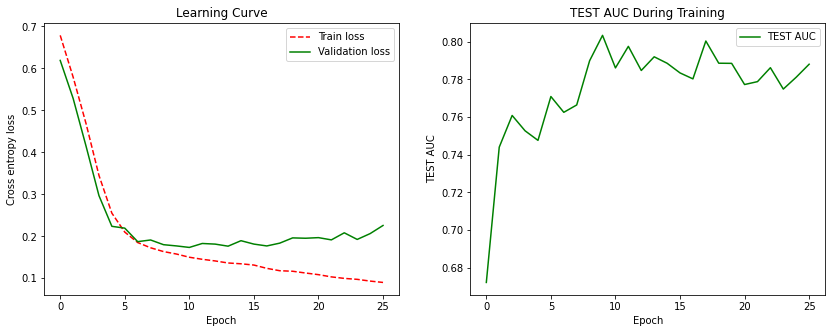


 Test AUC is 0.7861665884653727
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |   32600    |
|    GNN1.linear_0_v.bias    |    200     |
|     GNN1.bn_0_v.weight     |    200     |
|      GNN1.bn_0_v.bias      |    200     |
|   GNN1.linear_0_e.weight   |    3800    |
|    GNN1.linear_0_e.bias    |    200     |
|     GNN1.bn_0_e.weight     |    200     |
|      GNN1.bn_0_e.bias      |    200     |
|   GNN1.linear_0_g.weight   |   40000    |
|    GNN1.linear_0_g.bias    |    200     |
|     GNN1.bn_0_g.weight     |    200     |
|      GNN1.bn_0_g.bias      |    200     |
|   GNN1.linear_e_0.weight   |   240000   |
|    GNN1.linear_e_0.bias    |    200     |
|     GNN1.bn_e_0.weight     |    200     |
|      GNN1.bn_e_0.bias      |    200     |
|   GNN1.linear_e_1.weight   |   40000    |
|    GNN1.linear_e_1.bias    |    200     |
|     GNN1.bn_e_1.weight     |    200     |

1070524

In [ ]:
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = DGM(163,19,200,200,200,200,200,200,200,200,200,num_layers=1)
        self.GNN2 = DGM(200,200,200,100,100,100,100,100,100,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 30)
        self.linear_2 = nn.Linear(30, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(30)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _,_) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
count_parameters(model)

In [ ]:
class DGLDatasetTox(torch.utils.data.Dataset):

    def __init__(self):

        Tox21_dataset = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz', compression='gzip').fillna(0)

        self.smiles = []
        for o in range(len(Tox21_dataset)):
          self.smiles.append(Tox21_dataset.iloc[o,13])
          
    def __len__(self):
        return len(self.len(self.smiles))

    def __getitem__(self, idx):
        return  self.smiles[idx]